- Restore missing values (e.g. imputation)
- Add K-Fold cross-validation  (`Don` Once we identify all features to use, we can apply CV to sweep hyper-parameters)
- Account for seasonality in delays (`Don` weekofyear(FL_DATE) looks to capture seasonality pretty well)
- Account for daily traffics (`Don` include DEP_HOUR)
- Account for airport specific delay (`Don` consider including departure airport ID as a categorical(string) feature)
- Introduce delays as prior data
- Clean up EDA writeup
- Use tail number in arrival delay prediction
- Create cell to generate predictions using input data, models
- check rubrick
- `Taeil` (almost done) all the code should be part of function (running one cell should run whole model)

- EDA and Writing
  - better writing on the notebook 
  - objectives
  - update writing for ~~cancellation is part of delay?~~ (Kyle suggests we exclude them)
  - table that summarize various models and what we tried
  - include the code... something comprehensive (enough to let TAs grade the work without having to run the notebook)
  - For final presentation: Include succinct business summary
  - reference
  - why certain filters 
  - how filteres were choosen

- EDA and transformation
  - clear writings for eda
  - visualization of EDA (see other teams)

- not sure what this is 
  - Create cell to generate predictions using input data, models

- Feature Engineering / Model evaluation / model optimiazation 
  - check seasonality
  - fix missing values (I had to use dropna before running the model)
  - another variable of airport types size
  - `Taeil` ~~join on full dataset including test data~~
  - `Taeil` ~~transformation on full dataset~~
  - `Taeil` ~~held out 2019 data~~
  - `Taeil` ~~run model on full dataset~~
  - `Don` add cross validation
  - add delay as prior
  - Use tail number in arrival delay prediction
  - another variable of airport types size
  - Confusion matrix for models

#### Reference 


- [Airline dataset field description](https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236)
- [Understanding the Reporting of Causes of Flight Delays and Cancellations](https://www.bts.gov/topics/airlines-and-airports/understanding-reporting-causes-flight-delays-and-cancellations)
- [World Airport Codes](https://www.world-airport-codes.com/)
- [Weather Station List](http://dss.ucar.edu/datasets/ds353.4/inventories/station-list.html)
- [Weather isd-format-document](https://www.ncei.noaa.gov/data/global-hourly/doc/isd-format-document.pdf)

In [4]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, NullType, ShortType, DateType, BooleanType, BinaryType
from pyspark.sql import SQLContext

from pyspark.sql import types
import pyspark.sql.functions as F

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics

#MLlib
from pyspark.ml.feature import RFormula 
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from pyspark.ml.feature import VectorAssembler
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

sqlContext = SQLContext(sc)

DATA_PATH = 'dbfs:/mnt/mids-w261/data/datasets_final_project/'
MASTER_CORD_PATH = '/FileStore/tables/407131831_T_MASTER_CORD.csv'

/databricks/spark/python/pyspark/sql/context.py:77: DeprecationWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
 DeprecationWarning)

#### EDA Flights Data Set

Based on a preliminary exploration of the attributes available in the Airlines dataset, we identified seven main categories of data , summarized as follows:

  1. Time (Year, Quarter, Month, FL_DATE, DEP_TIME...) 
  2. Carriers
  3. Aiport and Geographical Information (ORIGIN_AIRPORT, DEST_AIRPORT)
  4. __Departure Delay Information__ ('DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_DELAY_GROUP', 'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'WEATHER_DELAY', 'NAS_DELAY'..)
  5. Arrival Delay Information
  6. Aircaft Attributes (TAXI, WHEELS) - assuming those data will not have before departure
  7. Route Information (e.g. Distance, diversions if applicable)
  
At this point, it quickly became apparent that the departure delay information attributes could be potential candidates for the outcome variable in our model.  Once we fleshed out our question formulation, we settled on using the DEP_DEL15 attribute as the outcome variable.  For more information on the rationale behind choosing this atttribute over DEP_DELAY_GROUP, please see the Question Formulation section of the main report.  At this point, we ruled out using the aircraft-related attributes group to build our models, as that we could not be certain that those variables will be available two hours prior to departure.

Of note is the two cancellation-based delay attributes, over which we initially held discussions over whether to try and incorporate them into our model in some way.  However, during the mid-project in-class presentations, it was recommended they be removed from the dataset altogether.  As a result, cancelled flights were removed from the model building process from both the train and test datasets.

- we can use 'DEP_DELAY_NEW' instead of 'DEP_DELAY'
- Cancelled (we can only include data that is cancelled with B and C). 
- `DEP_DELAY_OR_CANCELLED`Cancelled flight does not have delay value, so we should create another outcome variable that contains both dep_delay_new and cancelled. not clear how to merge :P 
- for baseline, we can focus on `DEP_DELAY_GROUP_NEW` consolidated version of `DEP_DELAY_GROUP_NEW`
- 'WEATHER_DELAY', 'NAS_DELAY' should be out intermediate outcome variables
- DEP_DELAY_GROUP has 14 category values

- diverted (inbound or outbound?) if this is for outbound, we can ignore. if this is for inbound, should we treat as significant factor for delay. Anyway, it is not output variable. 


Cancellation Code Description
- A	Carrier
- B	Weather
- C	National Air System
- D	Security

['DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_DELAY_GROUP', 'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'WEATHER_DELAY', 'NAS_DELAY']

- ~~(TO DISCUSS) For our baseline, we can use new variable that combines `DEP_DEL15` and `CANCELLED`~~ Kyle recommended we disregard cancelled flights

#### To remove
The most of fields can be filtered out because 
- they are neither inputs/outputs
- they are covered by other output variable
- (TODO) filter out 

#### Missing values
- In terms of null values, most of the diverted flights starting from DIV3 are empty, which is expected. Maybe we should just use 'DIVERTED' to represent all diverted flights information. 
- Distance should be included in the model as numeric data as well.
- airport does not have location info such as longitude and latitude information 

#### further discussion before finishing EDA
- ORG and DES airports, as well as flights if we count that as categorical, then regression will have a ton of dummy variables to interpret for the full set. (Might need to conside other models) However, this might correlated to weather data.
- Noting there are a section of delayed causes such as weather delay, carrier delay as delay in minutes, those variables might need to normailzed or coverted into categorical for model simplification. (Taeil suggest this to be the y variable, but when they sum up it doesn not equal to DEP_DELAY or DEP_DELAY_NEW)
- In order to form a predction model, I am not sure what variables will be provided before the departure or arrival, say if we have get a model with high correlation of late aircraft delay, we might not have this information two hours before the departure. (Wheels on/off, Taxi?)
- How to run the heatmap of correlations of all variables? To only include less correlated. 
- Use RDD to parse the data or Parquet? trainRDD, heldOutRDD = redsRDD.union(whitesRDD).randomSplit([0.8,0.2], seed = 1)

In [6]:
# (debugging) check mounted folders

display(dbutils.fs.ls("dbfs:/mnt/mids-w261/data/datasets_final_project/weather_data/weather2015a.parquet"))
#display(dbutils.fs.ls("dbfs:/mnt/mids-w261/data/datasets_final_project/airlines_data/2017"))
#display(dbutils.fs.ls("dbfs:/mnt/mids-w261/data/datasets_final_project/parquet_airlines_data/2015.parquet"))
#display(dbutils.fs.ls("dbfs:/mnt/mids-w261/data/datasets_final_project/parquet_airlines_data/2015.parquet/part-*.parquet"))
#display(dbutils.fs.ls("dbfs:/mnt/mids-w261/data/datasets_final_project/parquet_airlines_data/2017.parquet"))
#display(dbutils.fs.ls("dbfs:/mnt/mids-w261/data/datasets_final_project/parquet_airlines_data/2018.parquet"))
#display(dbutils.fs.ls("dbfs:/mnt/mids-w261/data/datasets_final_project/parquet_airlines_data/2018.parquet"))

#display(dbutils.fs.ls(DATA_PATH+"parquet_airlines_data_6m"))

path name size dbfs:/mnt/mids-w261/data/datasets_final_project/weather_data/weather2015a.parquet/_SUCCESS _SUCCESS 0 dbfs:/mnt/mids-w261/data/datasets_final_project/weather_data/weather2015a.parquet/_committed_6351095181992560034 _committed_6351095181992560034 6084 dbfs:/mnt/mids-w261/data/datasets_final_project/weather_data/weather2015a.parquet/_started_6351095181992560034 _started_6351095181992560034 0 dbfs:/mnt/mids-w261/data/datasets_final_project/weather_data/weather2015a.parquet/part-00000-tid-6351095181992560034-563bd7eb-71c5-45a8-839a-ed4a1f941eaf-3617-1-c000.snappy.parquet part-00000-tid-6351095181992560034-563bd7eb-71c5-45a8-839a-ed4a1f941eaf-3617-1-c000.snappy.parquet 109256889 dbfs:/mnt/mids-w261/data/datasets_final_project/weather_data/weather2015a.parquet/part-00001-tid-6351095181992560034-563bd7eb-71c5-45a8-839a-ed4a1f941eaf-3626-1-c000.snappy.parquet part-00001-tid-6351095181992560034-563bd7eb-71c5-45a8-839a-ed4a1f941eaf-3626-1-c000.snappy.parquet 98375438 dbfs:/mnt/mids-w261/data/datasets_final_project/weather_data/weather2015a.parquet/part-00002-tid-6351095181992560034-563bd7eb-71c5-45a8-839a-ed4a1f941eaf-3635-1-c000.snappy.parquet part-00002-tid-6351095181992560034-563bd7eb-71c5-45a8-839a-ed4a1f941eaf-3635-1-c000.snappy.parquet 97627735 dbfs:/mnt/mids-w261/data/datasets_final_project/weather_data/weather2015a.parquet/part-00003-tid-6351095181992560034-563bd7eb-71c5-45a8-839a-ed4a1f941eaf-3644-1-c000.snappy.parquet part-00003-tid-6351095181992560034-563bd7eb-71c5-45a8-839a-ed4a1f941eaf-3644-1-c000.snappy.parquet 89677996 dbfs:/mnt/mids-w261/data/datasets_final_project/weather_data/weather2015a.parquet/part-00004-tid-6351095181992560034-563bd7eb-71c5-45a8-839a-ed4a1f941eaf-3651-1-c000.snappy.parquet part-00004-tid-6351095181992560034-563bd7eb-71c5-45a8-839a-ed4a1f941eaf-3651-1-c000.snappy.parquet 85150252 dbfs:/mnt/mids-w261/data/datasets_final_project/weather_data/weather2015a.parquet/part-00005-tid-6351095181992560034-563bd7eb-71c5-45a8-839a-ed4a1f941eaf-3652-1-c000.snappy.parquet part-00005-tid-6351095181992560034-563bd7eb-71c5-45a8-839a-ed4a1f941eaf-3652-1-c000.snappy.parquet 58641349 dbfs:/mnt/mids-w261/data/datasets_final_project/weather_data/weather2015a.parquet/part-00006-tid-6351095181992560034-563bd7eb-71c5-45a8-839a-ed4a1f941eaf-3615-1-c000.snappy.parquet part-00006-tid-6351095181992560034-563bd7eb-71c5-45a8-839a-ed4a1f941eaf-3615-1-c000.snappy.parquet 105917556 dbfs:/mnt/mids-w261/data/datasets_final_project/weather_data/weather2015a.parquet/part-00007-tid-6351095181992560034-563bd7eb-71c5-45a8-839a-ed4a1f941eaf-3624-1-c000.snappy.parquet part-00007-tid-6351095181992560034-563bd7eb-71c5-45a8-839a-ed4a1f941eaf-3624-1-c000.snappy.parquet 99676419 dbfs:/mnt/mids-w261/data/datasets_final_project/weather_data/weather2015a.parquet/part-00008-tid-6351095181992560034-563bd7eb-71c5-45a8-839a-ed4a1f941eaf-3633-1-c000.snappy.parquet part-00008-tid-6351095181992560034-563bd7eb-71c5-45a8-839a-ed4a1f941eaf-3633-1-c000.snappy.parquet 93829273 dbfs:/mnt/mids-w261/data/datasets_final_project/weather_data/weather2015a.parquet/part-00009-tid-6351095181992560034-563bd7eb-71c5-45a8-839a-ed4a1f941eaf-3642-1-c000.snappy.parquet part-00009-tid-6351095181992560034-563bd7eb-71c5-45a8-839a-ed4a1f941eaf-3642-1-c000.snappy.parquet 86008249 dbfs:/mnt/mids-w261/data/datasets_final_project/weather_data/weather2015a.parquet/part-00010-tid-6351095181992560034-563bd7eb-71c5-45a8-839a-ed4a1f941eaf-3653-1-c000.snappy.parquet part-00010-tid-6351095181992560034-563bd7eb-71c5-45a8-839a-ed4a1f941eaf-3653-1-c000.snappy.parquet 82240354 dbfs:/mnt/mids-w261/data/datasets_final_project/weather_data/weather2015a.parquet/part-00011-tid-6351095181992560034-563bd7eb-71c5-45a8-839a-ed4a1f941eaf-3654-1-c000.snappy.parquet part-00011-tid-6351095181992560034-563bd7eb-71c5-45a8-839a-ed4a1f941eaf-3654-1-c000.snappy.parquet 60657771 dbfs:/mnt/mids-w261/data/datasets_final_project/weather_data/weather2015a.parquet/part-00012-tid-6351095181992560034-563bd

In [7]:
potential_outcome_vars = ['DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_DELAY_GROUP', 'CANCELLED', 'CANCELLATION_CODE', 'WEATHER_DELAY', 'NAS_DELAY']
# load airlines data
parquet_path = ["dbfs:/mnt/mids-w261/data/datasets_final_project/parquet_airlines_data_6m/part-*.parquet"]
airlines_6m = spark.read.option("header", "true").parquet(*parquet_path)


In [8]:
print(f"{len(airlines_6m.columns)} columns")
print()
print(airlines_6m.columns)

110 columns

['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE', 'OP_UNIQUE_CARRIER', 'OP_CARRIER_AIRLINE_ID', 'OP_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_CITY_MARKET_ID', 'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'ORIGIN_STATE_FIPS', 'ORIGIN_STATE_NM', 'ORIGIN_WAC', 'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'DEST_CITY_MARKET_ID', 'DEST', 'DEST_CITY_NAME', 'DEST_STATE_ABR', 'DEST_STATE_FIPS', 'DEST_STATE_NM', 'DEST_WAC', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_DELAY_GROUP', 'DEP_TIME_BLK', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'ARR_DELAY_NEW', 'ARR_DEL15', 'ARR_DELAY_GROUP', 'ARR_TIME_BLK', 'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'FLIGHTS', 'DISTANCE', 'DISTANCE_GROUP', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'FIRST_DEP_TIME', 'TOTAL_ADD_GTIME', 'LONGEST_ADD_GTIME', 'DIV_AIRPORT_LANDINGS', 'DIV_REACHED_DEST', 'DIV_ACTUAL_ELAPSED_TIME', 'DIV_ARR_DELAY', 'DIV_DISTANCE', 'DIV1_AIRPORT', 'DIV1_AIRPORT_ID', 'DIV1_AIRPORT_SEQ_ID', 'DIV1_WHEELS_ON', 'DIV1_TOTAL_GTIME', 'DIV1_LONGEST_GTIME', 'DIV1_WHEELS_OFF', 'DIV1_TAIL_NUM', 'DIV2_AIRPORT', 'DIV2_AIRPORT_ID', 'DIV2_AIRPORT_SEQ_ID', 'DIV2_WHEELS_ON', 'DIV2_TOTAL_GTIME', 'DIV2_LONGEST_GTIME', 'DIV2_WHEELS_OFF', 'DIV2_TAIL_NUM', 'DIV3_AIRPORT', 'DIV3_AIRPORT_ID', 'DIV3_AIRPORT_SEQ_ID', 'DIV3_WHEELS_ON', 'DIV3_TOTAL_GTIME', 'DIV3_LONGEST_GTIME', 'DIV3_WHEELS_OFF', 'DIV3_TAIL_NUM', 'DIV4_AIRPORT', 'DIV4_AIRPORT_ID', 'DIV4_AIRPORT_SEQ_ID', 'DIV4_WHEELS_ON', 'DIV4_TOTAL_GTIME', 'DIV4_LONGEST_GTIME', 'DIV4_WHEELS_OFF', 'DIV4_TAIL_NUM', 'DIV5_AIRPORT', 'DIV5_AIRPORT_ID', 'DIV5_AIRPORT_SEQ_ID', 'DIV5_WHEELS_ON', 'DIV5_TOTAL_GTIME', 'DIV5_LONGEST_GTIME', 'DIV5_WHEELS_OFF', 'DIV5_TAIL_NUM', 'DEP_HOUR']

In [9]:
display(airlines_6m)

YEAR QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK FL_DATE OP_UNIQUE_CARRIER OP_CARRIER_AIRLINE_ID OP_CARRIER TAIL_NUM OP_CARRIER_FL_NUM ORIGIN_AIRPORT_ID ORIGIN_AIRPORT_SEQ_ID ORIGIN_CITY_MARKET_ID ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR ORIGIN_STATE_FIPS ORIGIN_STATE_NM ORIGIN_WAC DEST_AIRPORT_ID DEST_AIRPORT_SEQ_ID DEST_CITY_MARKET_ID DEST DEST_CITY_NAME DEST_STATE_ABR DEST_STATE_FIPS DEST_STATE_NM DEST_WAC CRS_DEP_TIME DEP_TIME DEP_DELAY DEP_DELAY_NEW DEP_DEL15 DEP_DELAY_GROUP DEP_TIME_BLK TAXI_OUT WHEELS_OFF WHEELS_ON TAXI_IN CRS_ARR_TIME ARR_TIME ARR_DELAY ARR_DELAY_NEW ARR_DEL15 ARR_DELAY_GROUP ARR_TIME_BLK CANCELLED CANCELLATION_CODE DIVERTED CRS_ELAPSED_TIME ACTUAL_ELAPSED_TIME AIR_TIME FLIGHTS DISTANCE DISTANCE_GROUP CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY FIRST_DEP_TIME TOTAL_ADD_GTIME LONGEST_ADD_GTIME DIV_AIRPORT_LANDINGS DIV_REACHED_DEST DIV_ACTUAL_ELAPSED_TIME DIV_ARR_DELAY DIV_DISTANCE DIV1_AIRPORT DIV1_AIRPORT_ID DIV1_AIRPORT_SEQ_ID DIV1_WHEELS_ON DIV1_TOTAL_GTIME DIV1_LONGEST_GTIME DIV1_WHEELS_OFF DIV1_TAIL_NUM DIV2_AIRPORT DIV2_AIRPORT_ID DIV2_AIRPORT_SEQ_ID DIV2_WHEELS_ON DIV2_TOTAL_GTIME DIV2_LONGEST_GTIME DIV2_WHEELS_OFF DIV2_TAIL_NUM DIV3_AIRPORT DIV3_AIRPORT_ID DIV3_AIRPORT_SEQ_ID DIV3_WHEELS_ON DIV3_TOTAL_GTIME DIV3_LONGEST_GTIME DIV3_WHEELS_OFF DIV3_TAIL_NUM DIV4_AIRPORT DIV4_AIRPORT_ID DIV4_AIRPORT_SEQ_ID DIV4_WHEELS_ON DIV4_TOTAL_GTIME DIV4_LONGEST_GTIME DIV4_WHEELS_OFF DIV4_TAIL_NUM DIV5_AIRPORT DIV5_AIRPORT_ID DIV5_AIRPORT_SEQ_ID DIV5_WHEELS_ON DIV5_TOTAL_GTIME DIV5_LONGEST_GTIME DIV5_WHEELS_OFF DIV5_TAIL_NUM 2015 2 4 23 4 2015-04-23 AA 19805 AA N3FJAA 165 13930 1393003 30977 ORD Chicago, IL IL 17 Illinois 41 14107 1410702 30466 PHX Phoenix, AZ AZ 4 Arizona 81 1210 1202 -8.0 0.0 0.0 -1 1200-1259 15.0 1217 1356 6.0 1414 1402 -12.0 0.0 0.0 -1 1400-1459 0.0 null 0.0 244.0 240.0 219.0 1.0 1440.0 6 null null null null null null null null 0 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null 2015 2 4 24 5 2015-04-24 AA 19805 AA N3BAAA 165 13930 1393003 30977 ORD Chicago, IL IL 17 Illinois 41 14107 1410702 30466 PHX Phoenix, AZ AZ 4 Arizona 81 1210 1214 4.0 4.0 0.0 0 1200-1259 19.0 1233 1417 12.0 1414 1429 15.0 15.0 1.0 1 1400-1459 0.0 null 0.0 244.0 255.0 224.0 1.0 1440.0 6 0.0 0.0 15.0 0.0 0.0 null null null 0 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null 2015 2 4 25 6 2015-04-25 AA 19805 AA N3CUAA 165 13930 1393003 30977 ORD Chicago, IL IL 17 Illinois 41 14107 1410702 30466 PHX Phoenix, AZ AZ 4 Arizona 81 1210 1254 44.0 44.0 1.0 2 1200-1259 24.0 1318 1441 4.0 1414 1445 31.0 31.0 1.0 2 1400-1459 0.0 null 0.0 244.0 231.0 203.0 1.0 1440.0 6 31.0 0.0 0.0 0.0 0.0 null null null 0 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null 2015 2 4 26 7 2015-04-26 AA 19805 AA N3HKAA 165 13930 1393003 30977 ORD Chicago, IL IL 17 Illinois 41 14107 1410702 30466 PHX Phoenix, AZ AZ 4 Arizona 81 1210 1205 -5.0 0.0 0.0 -1 1200-1259 11.0 1216 1326 4.0 1414 1330 -44.0 0.0 0.0 -2 1400-1459 0.0 null 0.0 244.0 205.0 190.0 1.0 1440.0 6 null null null null null null null null 0 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null 2015 2 4 27 1 2015-04-27 AA 19805 AA N3DMAA 165 13930 1393003 30977 ORD Chicago, IL IL 17 Illinois 41 14107 1410702 30466 PHX Phoenix, AZ AZ 4 Arizona 81 1210 1219 9.0 9.0 0.0 0 1200-1259 11.0 1230 1328 22.0 141

Once we had explored the feature categories, the next step was to start looking at the airline flight data itself.  As a first pass, we started by looking at the six-month dataset.  In addition to the limited time dimension, we quickly noticed that the file only contained data on two airports - ATL (Hartsfield–Jackson Atlanta International Airport) and ORD (Chicago O'Hare International Airport).  This was only a tiny fraction of the airport count in the full dataset, which contained 322 airports.

for 6m EDA dataset, there is only two airport ATL, ORD. 
for train data set, 2015 - 2018, there is 322 airport.
train airline size: 24324804 
test airline size: 7422037
[KP NOTE: This isn't accurate anymore after we changed the train and holdout datasets to reflect the mid-project feedback, right?]

In [11]:
display(airlines_6m.select("ORIGIN").distinct().collect())

ORIGIN ATL ORD

In order to visualize the data, we started plotting some histograms on the six month dataset.  Despite the fact that the dataset only contained two airports, we discovered that flight counts didn't show much seasonal variation by day of month, day of week, or calendar month.  We attributed this to the large size of these airports, as hubs carry large volumes of air traffic at all times.  As well, we noticed that flight information varied significantly between carriers [KP NOTE: Which attributes showed those differences? Need to clarify]

Original notes:
- For 6m EDA dataset histogram, we found: 
  1. The flight counts has no significant seasonality, probabily because those two ariports are fairly large.
  2. The flights has significant differences between Carriers

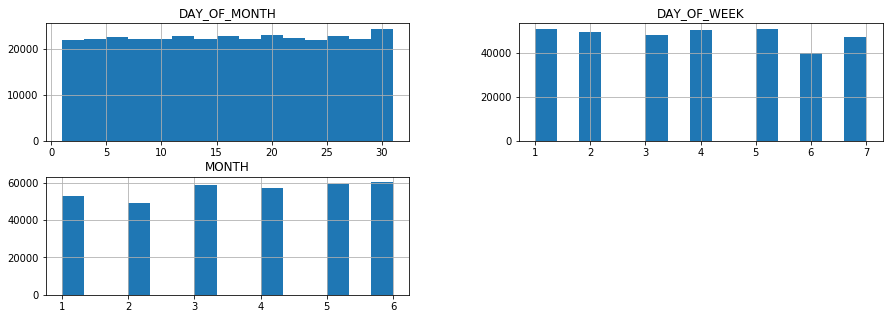

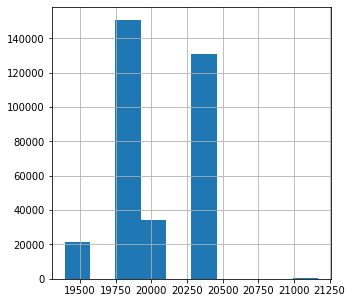

In [13]:
# Take a look at histograms for each feature 
# Convert it to pandas dataframe
FIELDS = airlines_6m.columns
airline_pd = airlines_6m.select("*").toPandas()

# Check for day, week, and month of data, no significant differences
airline_pd[FIELDS[2:5]].hist(figsize=(15,5), bins=15)
display(plt.show())

# Check for Carrier distribution
airline_pd[FIELDS[7]].hist(figsize=(5,5))
display(plt.show())

An aggregation of the destination airports showed that the counts were significantly skewed towards other large airports as well.  For example, there were 9,769 flights from these two airports to LGA (LaGuardia, New York), but only two outbound flights to COD (Yellowstone Regional Airport, Wyoming) in the given timeframe.  While fairly obvious, this distribution functioned as a sanity check.

ORIGINAL NOTES:
  3.The flights numbers to different destination airports are not distributed. LGA has about 9700 flights and COD only has 2 flights in the first 6 months of 2015.

In [15]:
# Count for the airports 
print(airline_pd.DEST.value_counts())

LGA 9769
DFW 8060
LAX 6944
MCO 6862
DCA 6764
 ... 
STX 26
GUC 15
MSO 6
ONT 3
COD 2
Name: DEST, Length: 196, dtype: int64

After verifying the outbound flight counts against our expectations, we turned back to exploring time-based attributes.  By plotting the counts of flights departing by hour of day, we found that the vast majority of flights occur between 5 AM to 9 PM.

ORIGINAL NOTES:
    4.Depature happens mainly between 5 a.m. to 9 p.m.

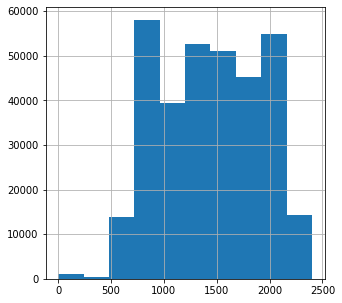

In [17]:
# Check for Departure Time by hour
airline_pd['DEP_TIME'].hist(figsize=(5,5), bins=10)
display(plt.show())

Next came plotting the departure delay attributes.  We quickly noticed that DEP_DEL15 attribute was a binary variable, with 0 indicating a delay of less than 15 minutes, and 1 indicating a delay of more than 15 minutes.  Accordingly, the DEP_DELAY variable, which measures flight delay in minutes, is heavily skewed towards lower delay values.  This carried over to the DEP_DELAY_GROUP attribute, which buckets the delays in 15-minute increments.  Here, we noticed that the DEP_DELAY_NEW feature was essentially the same as DEP_DELAY, but with delays of less than 0 minutes (i.e. early departures) set to a delay value of zero.


ORIGINAL NOTES:

 5.For the Depature Delay variables:
 
 "DEP_DEL15" is a Binary variable 0 - not delayed 15 mins; 1 - delyed more than 15 mins.
 
 "DEP_DELAY" is a flight delay in minutes, which is extremely skewed. 
 
 "DEP_DELAY_GROUP" is categorical variable which bins the "DEP_DELAY" in 15 minutes; and we can also see that the groups are also skewed. Majority of deleyed flights are in group 1 to 3.
 
 "DEP_DELAY_NEW" is also flight delay in minutes but it removed the negative values.

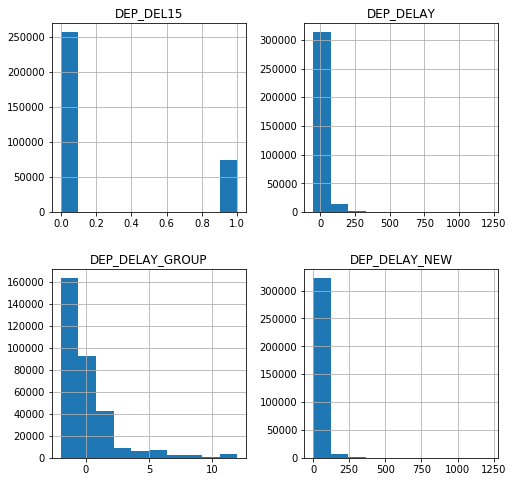

In [19]:
# Check for Delays
airline_pd[FIELDS[31:35]].hist(figsize=(8,8))
display(plt.show())

When we started plotting the arrival delays, we noticed that the attribute types, as well as the histogram distributions were almost identical to their departure counterparts, right down to the skew.  Based on the fact that the 15 minute arrival delay attribute was proportionally similar to the 15 minute departure delay variable, we considered that the two variables might be correlated with each other.

ORIGINAL NOTES:

6.For Arrival Delay and other delays: __(Histogram of ARR DELAY and DEP DELAY are almost identical)__

 "ARR_DEL15" is a Binary variable 0 - not delayed 15 mins; 1 - delyed more than 15 mins. *we can see roughly the same amount of flights get delayed for more than 15 mins in ARRVIAL DELAY to DEPARTURE DELAY. These two variables might be correlated.*
 
 "ARR_DELAY" is a flight delay in minutes, which is also extremely skewed. 
 
 "ARR_DELAY_GROUP" is categorical variable which bins the "DEP_DELAY" in 15 minutes; and we can also see that the groups are also skewed. Majority of deleyed flights are in group 1 to 3.
 
 "ARR_DELAY_NEW" is also flight delay in minutes but it removed the negative values.
 
 All other delays are also extremely skewed, we probably can take a mean instead of average as input variable.

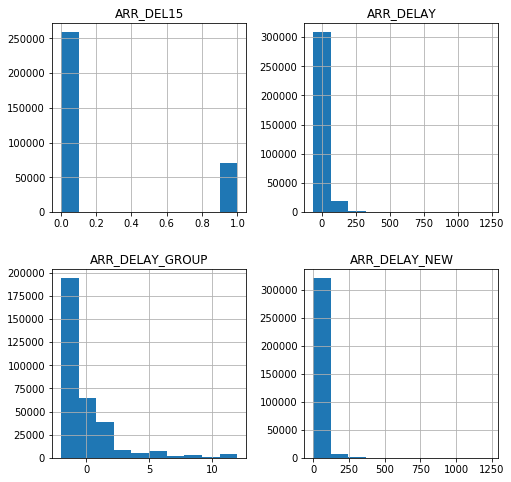

In [21]:
# Check for Arrival Delay
airline_pd[FIELDS[42:46]].hist(figsize=(8,8), bins=10)
display(plt.show())

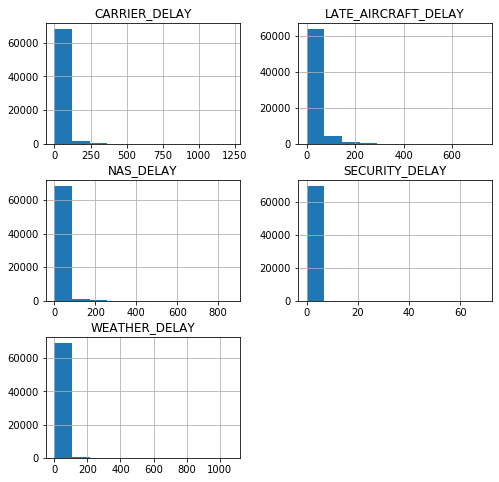

In [22]:
# Check for other delays
airline_pd[FIELDS[56:61]].hist(figsize=(8,8), bins=10)
display(plt.show())

In [23]:
# Load Dataset for training and testing
parquet_path = ["dbfs:/mnt/mids-w261/data/datasets_final_project/parquet_airlines_data/2015.parquet", 
                "dbfs:/mnt/mids-w261/data/datasets_final_project/parquet_airlines_data/2016.parquet",
                "dbfs:/mnt/mids-w261/data/datasets_final_project/parquet_airlines_data/2017.parquet",
                "dbfs:/mnt/mids-w261/data/datasets_final_project/parquet_airlines_data/2018.parquet"]
airlines_train = spark.read.option("header", "true").parquet(*parquet_path)

parquet_path = ["dbfs:/mnt/mids-w261/data/datasets_final_project/parquet_airlines_data/2019.parquet"] 
airlines_test = spark.read.option("header", "true").parquet(*parquet_path)
                
airline_train_size = airlines_train.count()
airlines_train.select("ORIGIN").distinct().count()

airline_test_size = airlines_test.count()
airlines_test.select("ORIGIN").distinct().count()

print(airline_train_size,  airline_test_size)

24324804 7422037

In [24]:
#airline_columns_tokeep = ['DEP_DEL15', 'WEATHER_DELAY', 'NAS_DELAY', 'CARRIER_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'MONTH', 'DAY_OF_WEEK', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'DEP_TIME', 'FL_DATE', "DEP_HOUR"]
airline_columns_tokeep = ['DEP_DEL15', 'WEATHER_DELAY', 'NAS_DELAY', 'ARR_DELAY', 'ARR_DELAY_NEW', 'CARRIER_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'DEP_TIME', 'FL_DATE', "DEP_HOUR", "DAY_OF_WEEK", "DAY_OF_MONTH"]

def load_airline_data():

    def transform_airline_data(parquet_path):
        """
        read from s3 parquets
        transform given airline dataset to
        - for delay fields, replace null value by zero
        """
        
        airlines = spark.read.option("header", "true").parquet(*parquet_path)
          
        # Seperate DEP_TIME into Hour for join (We might want to use TimeStamp values with date to join for 2 hours before)
        airlines = airlines.withColumn("DEP_HOUR", F.bround('DEP_TIME', -2)/100)

        # drop cancelled flight for baseline 
        #airlines = airlines.where(F.col('cancelled') == 0).select(airline_columns_tokeep)
        airlines = airlines.where(F.col('cancelled') == 0)

        # replace null value by zeros
        airlines = airlines.withColumn('NAS_DELAY', F.when(airlines['NAS_DELAY'].isNull(), 0).otherwise(airlines['NAS_DELAY']) )
        airlines = airlines.withColumn('WEATHER_DELAY', F.when(airlines['WEATHER_DELAY'].isNull(), 0).otherwise(airlines['WEATHER_DELAY']) )
        airlines = airlines.withColumn('SECURITY_DELAY', F.when(airlines['SECURITY_DELAY'].isNull(), 0).otherwise(airlines['SECURITY_DELAY']) )
        airlines = airlines.withColumn('LATE_AIRCRAFT_DELAY', F.when(airlines['LATE_AIRCRAFT_DELAY'].isNull(), 0).otherwise(airlines['LATE_AIRCRAFT_DELAY']) )
        airlines = airlines.withColumn('CARRIER_DELAY', F.when(airlines['CARRIER_DELAY'].isNull(), 0).otherwise(airlines['CARRIER_DELAY']) )
        airlines = airlines.withColumn('ARR_DELAY', F.when(airlines['ARR_DELAY'].isNull(), 0).otherwise(airlines['ARR_DELAY']) )
        airlines = airlines.withColumn('ARR_DELAY_NEW', F.when(airlines['ARR_DELAY_NEW'].isNull(), 0).otherwise(airlines['ARR_DELAY_NEW']) )
        
        return airlines
  
    # load airlines data
    parquet_path = ["dbfs:/mnt/mids-w261/data/datasets_final_project/parquet_airlines_data/2015.parquet", 
                    "dbfs:/mnt/mids-w261/data/datasets_final_project/parquet_airlines_data/2016.parquet",
                    "dbfs:/mnt/mids-w261/data/datasets_final_project/parquet_airlines_data/2017.parquet",
                    "dbfs:/mnt/mids-w261/data/datasets_final_project/parquet_airlines_data/2018.parquet"]
    airline_train = transform_airline_data(parquet_path)
    
    parquet_path = ["dbfs:/mnt/mids-w261/data/datasets_final_project/parquet_airlines_data/2019.parquet"] 
    airline_test = transform_airline_data(parquet_path)
    
    parquet_path = ["dbfs:/mnt/mids-w261/data/datasets_final_project/parquet_airlines_data_6m/part-*.parquet"] 
    airline_6m = transform_airline_data(parquet_path)
      
    return airline_train, airline_test, airline_6m

airline_train, airline_test, airlines_6m = load_airline_data()
display(airline_train.sample(False, 0.00001))

YEAR QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK FL_DATE OP_UNIQUE_CARRIER OP_CARRIER_AIRLINE_ID OP_CARRIER TAIL_NUM OP_CARRIER_FL_NUM ORIGIN_AIRPORT_ID ORIGIN_AIRPORT_SEQ_ID ORIGIN_CITY_MARKET_ID ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR ORIGIN_STATE_FIPS ORIGIN_STATE_NM ORIGIN_WAC DEST_AIRPORT_ID DEST_AIRPORT_SEQ_ID DEST_CITY_MARKET_ID DEST DEST_CITY_NAME DEST_STATE_ABR DEST_STATE_FIPS DEST_STATE_NM DEST_WAC CRS_DEP_TIME DEP_TIME DEP_DELAY DEP_DELAY_NEW DEP_DEL15 DEP_DELAY_GROUP DEP_TIME_BLK TAXI_OUT WHEELS_OFF WHEELS_ON TAXI_IN CRS_ARR_TIME ARR_TIME ARR_DELAY ARR_DELAY_NEW ARR_DEL15 ARR_DELAY_GROUP ARR_TIME_BLK CANCELLED CANCELLATION_CODE DIVERTED CRS_ELAPSED_TIME ACTUAL_ELAPSED_TIME AIR_TIME FLIGHTS DISTANCE DISTANCE_GROUP CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY FIRST_DEP_TIME TOTAL_ADD_GTIME LONGEST_ADD_GTIME DIV_AIRPORT_LANDINGS DIV_REACHED_DEST DIV_ACTUAL_ELAPSED_TIME DIV_ARR_DELAY DIV_DISTANCE DIV1_AIRPORT DIV1_AIRPORT_ID DIV1_AIRPORT_SEQ_ID DIV1_WHEELS_ON DIV1_TOTAL_GTIME DIV1_LONGEST_GTIME DIV1_WHEELS_OFF DIV1_TAIL_NUM DIV2_AIRPORT DIV2_AIRPORT_ID DIV2_AIRPORT_SEQ_ID DIV2_WHEELS_ON DIV2_TOTAL_GTIME DIV2_LONGEST_GTIME DIV2_WHEELS_OFF DIV2_TAIL_NUM DIV3_AIRPORT DIV3_AIRPORT_ID DIV3_AIRPORT_SEQ_ID DIV3_WHEELS_ON DIV3_TOTAL_GTIME DIV3_LONGEST_GTIME DIV3_WHEELS_OFF DIV3_TAIL_NUM DIV4_AIRPORT DIV4_AIRPORT_ID DIV4_AIRPORT_SEQ_ID DIV4_WHEELS_ON DIV4_TOTAL_GTIME DIV4_LONGEST_GTIME DIV4_WHEELS_OFF DIV4_TAIL_NUM DIV5_AIRPORT DIV5_AIRPORT_ID DIV5_AIRPORT_SEQ_ID DIV5_WHEELS_ON DIV5_TOTAL_GTIME DIV5_LONGEST_GTIME DIV5_WHEELS_OFF DIV5_TAIL_NUM DEP_HOUR 2018 1 1 17 3 2018-01-17 AA 19805 AA N173US 615 14107 1410702 30466 PHX Phoenix, AZ AZ 4 Arizona 81 13930 1393006 30977 ORD Chicago, IL IL 17 Illinois 41 1951 1951 0.0 0.0 0.0 0 1900-1959 13.0 2004 11 7.0 18 18 0.0 0.0 0.0 0 0001-0559 0.0 null 0.0 207.0 207.0 187.0 1.0 1440.0 6 0.0 0.0 0.0 0.0 0.0 null null null 0 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null 20.0 2018 1 1 6 6 2018-01-06 OH 20397 OH N213PS 5428 11641 1164102 31641 FAY Fayetteville, NC NC 37 North Carolina 36 11057 1105703 31057 CLT Charlotte, NC NC 37 North Carolina 36 1413 1512 59.0 59.0 1.0 3 1400-1459 7.0 1519 1552 5.0 1525 1557 32.0 32.0 1.0 2 1500-1559 0.0 null 0.0 72.0 45.0 33.0 1.0 118.0 1 6.0 0.0 0.0 0.0 26.0 null null null 0 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null 15.0 2016 4 11 30 3 2016-11-30 UA 19977 UA N446UA 1284 14679 1467903 33570 SAN San Diego, CA CA 6 California 91 12266 1226603 31453 IAH Houston, TX TX 48 Texas 74 848 845 -3.0 0.0 0.0 -1 0800-0859 18.0 903 1334 8.0 1351 1342 -9.0 0.0 0.0 -1 1300-1359 0.0 null 0.0 183.0 177.0 151.0 1.0 1303.0 6 0.0 0.0 0.0 0.0 0.0 null null null 0 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null 8.0 2016 4 11 10 4 2016-11-10 DL 19790 DL N3760C 1535 10397 1039705 30397 ATL Atlanta, GA GA 13 Georgia 34 12339 1233904 32337 IND Indianapolis, IN IN 18 Indiana 42 2109 2112 3.0 3.0 0.0 0 2100-2159 41.0 2153 2251 4.0 2244 2255 11.0 11.0 0.0 0 2200-2259 0.0 null 0.0 95.0 103.0 58.0 1.0 432.0 2 0.0 0.0 0.0 0.0 0.0 null null null 0 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null 21.0 2016 4 11 24 4 2016-11-24 WN 19393 WN N8699A 2816 12191 1219102 31453 HOU Houston, TX TX 48 Texas 74 12889 1288903 32211 LAS Las Vegas, NV NV 32 Nevada 85 1115 1111 -4.0 0.0 0.0 -1 1100-

In [25]:
flights_with_delay = airline_train.where(F.col('dep_del15') == 1).count()
flights_with_nodelay = airline_train.where(F.col('dep_del15') == 0).count()
print("flights with delay:", flights_with_delay)
print("flights with no delay:", flights_with_nodelay)
print(f"likihood of flight delay: {flights_with_delay/flights_with_nodelay:.2f}")

flights with delay: 4324485
flights with no delay: 19640553
likihood of flight delay: 0.22

At this point, we started looking for relationships between the departure delay attributes and data from the other six main attribute categories in the airlines data.

ORIIGNAL NOTES:

As mentioned before, there are 7 main categories of data:

1. Time (Year, Quarter, Month, FL_DATE, DEP_TIME...)
2. Carriers
3. Aiport and Geolocatoin Information (ORIGIN_AIRPORT, DEST_AIRPORT)
4. Departure Delay Information ('DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_DELAY_GROUP', 'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'WEATHER_DELAY', 'NAS_DELAY'..)
5. Airplane information (TAXI, WHEELS) - assuming those data will not have before departure
6. Arrival Delay Information
7. Route Information (Diverted, Distance)

Now, we can take a look for the relationship between DEPATURE DELAY to the other 6 categories

In [27]:
# Making a sample set of the full training set to conduct EDA 
sample_train = airline_train.sample(False, 0.001, 42)
print(sample_train.count())
sample_df = sample_train.toPandas()

# Get the related features
airline_columns_tokeep = ['DEP_DEL15', 'DEP_DELAY_GROUP', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK','DEP_HOUR', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'WEATHER_DELAY', 'NAS_DELAY', 'CARRIER_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY',  'ARR_DELAY', 'DISTANCE', 'DIV_AIRPORT_LANDINGS']
sample_df2 = sample_df[airline_columns_tokeep]

24099

When we took a sample of the training dataset for the EDA and plotted the categorical data, we noticed that the data told us a different story from the six month subset.  For example, seasonality now became visible in the broader dataset, with the summer months (June through August) and December having higher a higher probability of flight delay than in other months.  We also noticed that late-night flights (with a departure time between 11PM to 3AM) were prone to significantly higher delay probabilities than at other times of day.  Finally, plotting the probability of delay against airport IDs showed us that there was significant variation in the probability of flight delay between airports.

ORIGINAL NOTES:

-For Categorical Data:
- __It seems there is a significant factor of seasonality, we can see the summer months (6-8) and December has higher delay possibilities__
- __During the midnight (11pm-3am) has a significant higher possibility of getting delayer__
- __We can see there are several airport ID (Origin and Destination) has different delay rates.

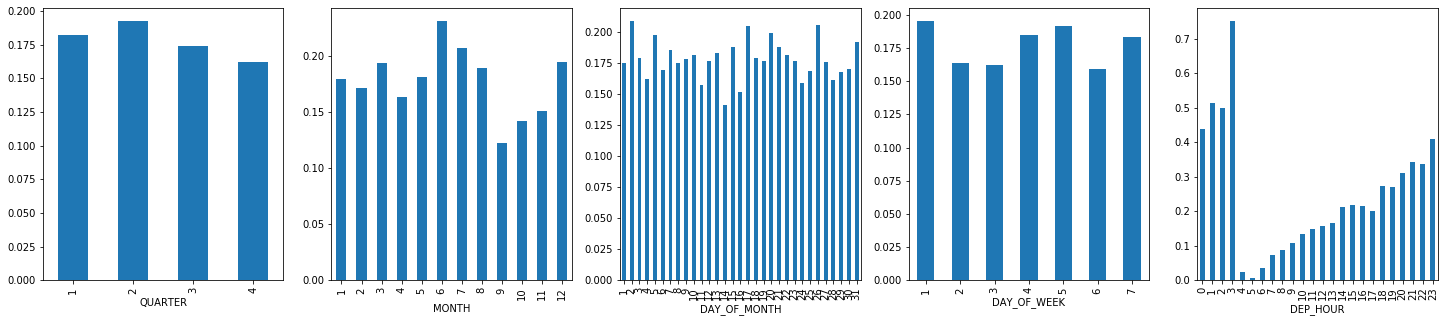

In [29]:
# Check the correlations between time-related features and DEL15
# plot the delay rates versus each time measure 
plt.figure(figsize = (25,5))
plt.subplot(1,5,1)
sample_df2.groupby("QUARTER")["DEP_DEL15"].mean().plot.bar()
plt.subplot(1,5,2)
sample_df2.groupby("MONTH")["DEP_DEL15"].mean().plot.bar()
plt.subplot(1,5,3)
sample_df2.groupby("DAY_OF_MONTH")["DEP_DEL15"].mean().plot.bar()
plt.subplot(1,5,4)
sample_df2.groupby("DAY_OF_WEEK")["DEP_DEL15"].mean().plot.bar()
plt.subplot(1,5,5)
sample_df2.groupby("DEP_HOUR")["DEP_DEL15"].mean().plot.bar()

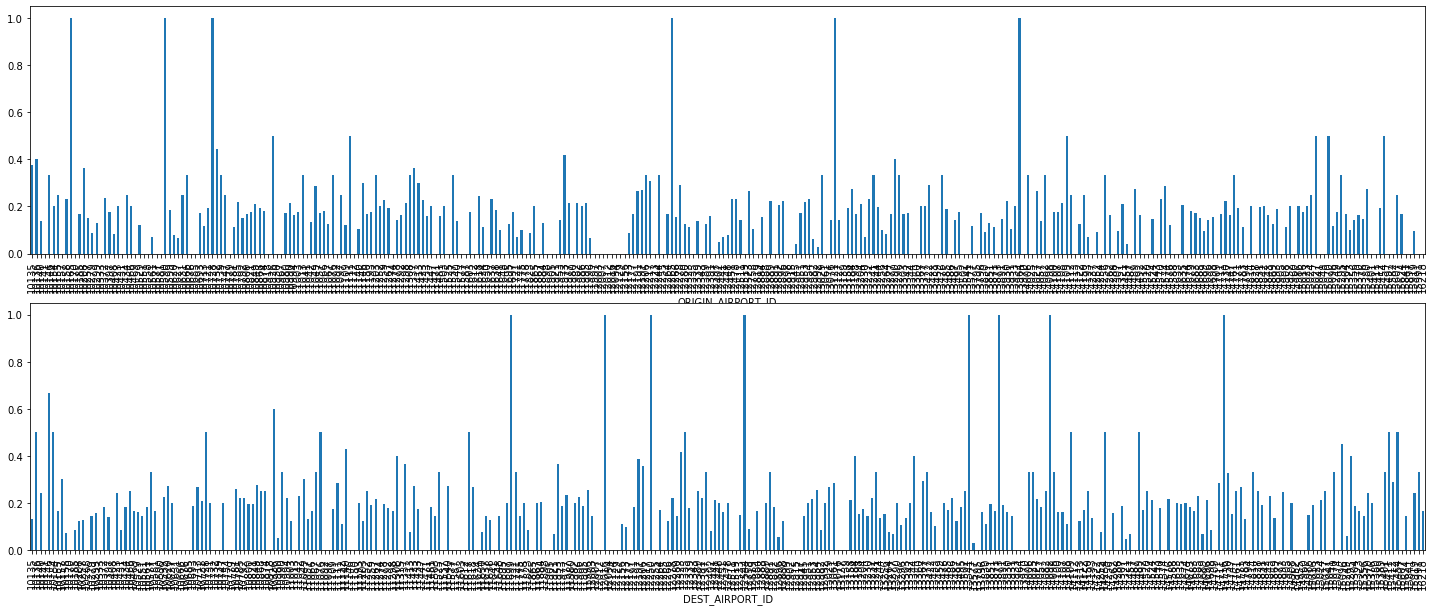

In [30]:
# plot the delay rates versus each time measure 
plt.figure(figsize = (25,10))
plt.subplot(2,1,1)
sample_df2.groupby("ORIGIN_AIRPORT_ID")["DEP_DEL15"].mean().plot.bar()
plt.subplot(2,1,2)
sample_df2.groupby("DEST_AIRPORT_ID")["DEP_DEL15"].mean().plot.bar()

After plotting the categorical data, we repeated the exercise on the continuous data.  From this, we learned that all of the individual delay features (weather, NAS, carrier, and security) are significantly correlated with the `DEP_DEL15` and `DEP_DELAY_GROUP` attributes.  As well, the arrival delay attribute also shows large differences between `DEP_DEL15` = 0 and `DEP_DEL15` = 1.  This makes logical sense, because when a flight's departure is delayed, its arrival will normally be delayed as well (this can be alleviated with higher flight speeds, but that's only an option in certain cases).  From this, we got the idea that delays in the prior arrival of a flight might be useful in predicting delays in subsequent departures.  Finally, the distance and diversion attributes did not seem to have any significant impact on the delay attributes.


ORIGINAL NOTES: 

For continuous variables:
- __All of the other DELAY features has significant correlation to DEP_DEL15 and DEP_DELAY_GROUP based on these highly skewed plots__, We can see the long tail of DELAY = 1.
- __ARRIVAL DELAY is also has quite big difference between DEP_DEL15 = 0 and DEP_DEL15 = 1, which logically makes sense that when the departure is delayed then arrival will normally be delayed. Maybe it works backwards.__
- The distance and Diversion seems does not have significant impact on the delays.

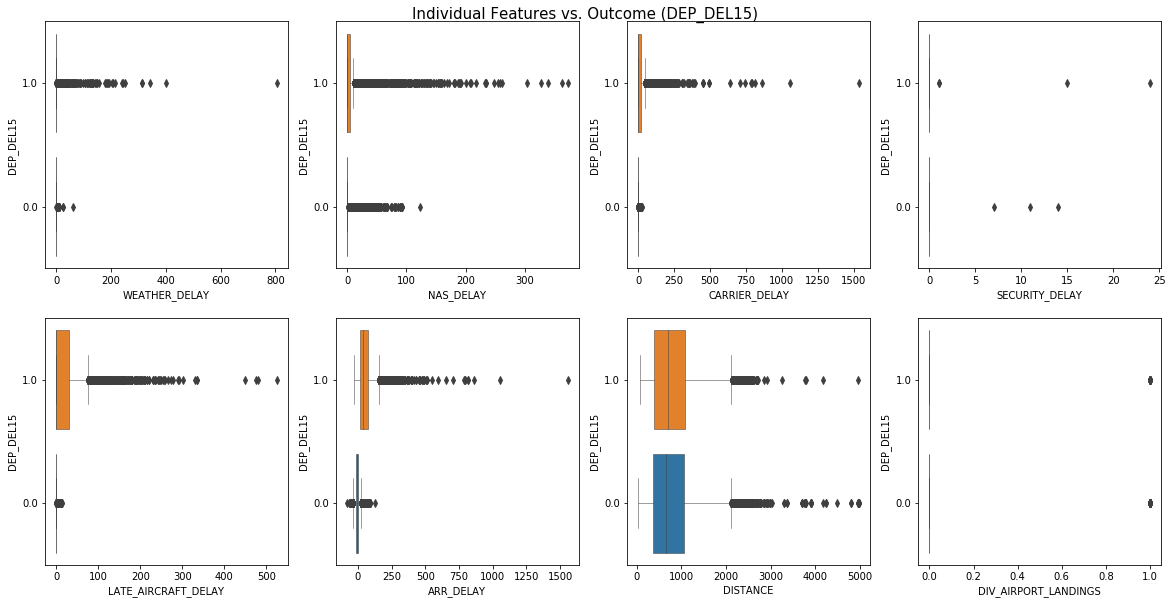

In [32]:
fig, ax_grid = plt.subplots(2, 4, figsize=(20,10))
y = sample_df2['DEP_DEL15']
FIELDS = sample_df2.columns
for idx, feature in enumerate(FIELDS[9:]):
    x = sample_df[feature]
    sns.boxplot(x, y, ax=ax_grid[idx//4][idx%4], orient='h', linewidth=.5)
    ax_grid[idx//4][idx%4].invert_yaxis()
fig.suptitle("Individual Features vs. Outcome (DEP_DEL15)", fontsize=15, y=0.9)
display(plt.show())

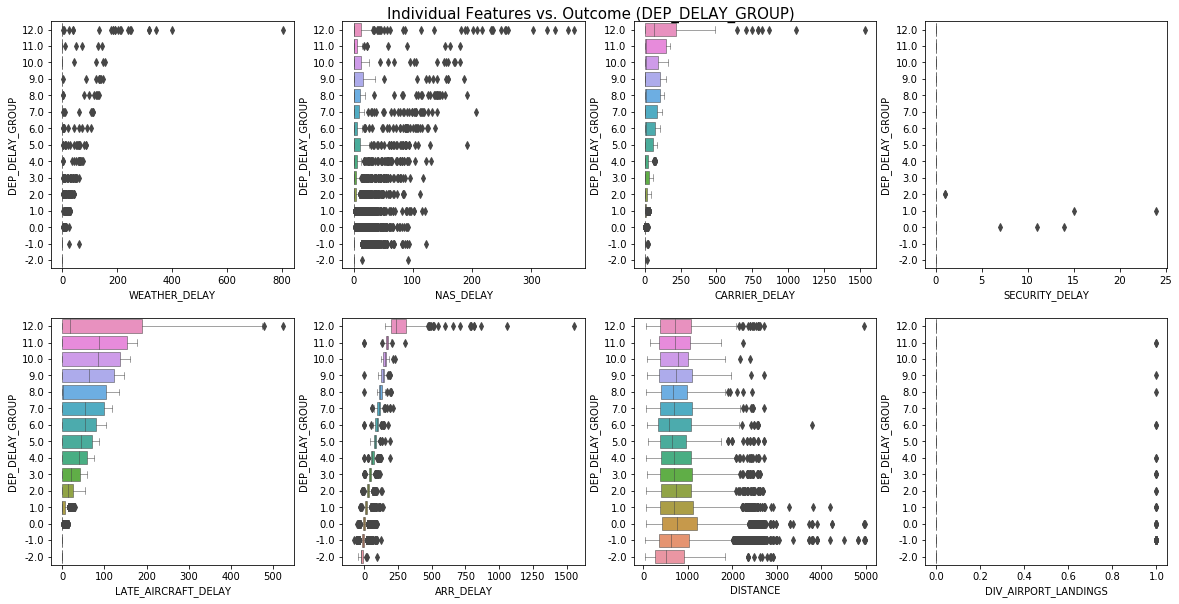

In [33]:
fig, ax_grid = plt.subplots(2, 4, figsize=(20,10))
y = sample_df2['DEP_DELAY_GROUP']
FIELDS = sample_df2.columns
for idx, feature in enumerate(FIELDS[9:]):
    x = sample_df[feature]
    sns.boxplot(x, y, ax=ax_grid[idx//4][idx%4], orient='h', linewidth=.5)
    ax_grid[idx//4][idx%4].invert_yaxis()
fig.suptitle("Individual Features vs. Outcome (DEP_DELAY_GROUP)", fontsize=15, y=0.9)
display(plt.show())

Based on the correlation heat map that we ran on the initial feature selection, we observed that `DEP_DEL15` was correlated with the hour of departure, as well as the other delay attributes (weather, NAS, carrier, late aircraft, and arrival), which was expected.  We also saw that there were inner correlations between arrival delay and the other delay categories, as well as departure hour.

ORIGINAL NOTES:

- __Initial Feature Selection:__
  1. We can easily see the correlation between DEP_DEL15 to 'DEP_HOUR','WEATHER_DELAY', 'NAS_DELAY', 'CARRIER_DELAY', 'LATE_AIRCRAFT_DELAY', 'ARR_DELAY'.
  2. Also, there are inner correlations between ARR_DELAY to Other delays and 'DEP_HOUR'.

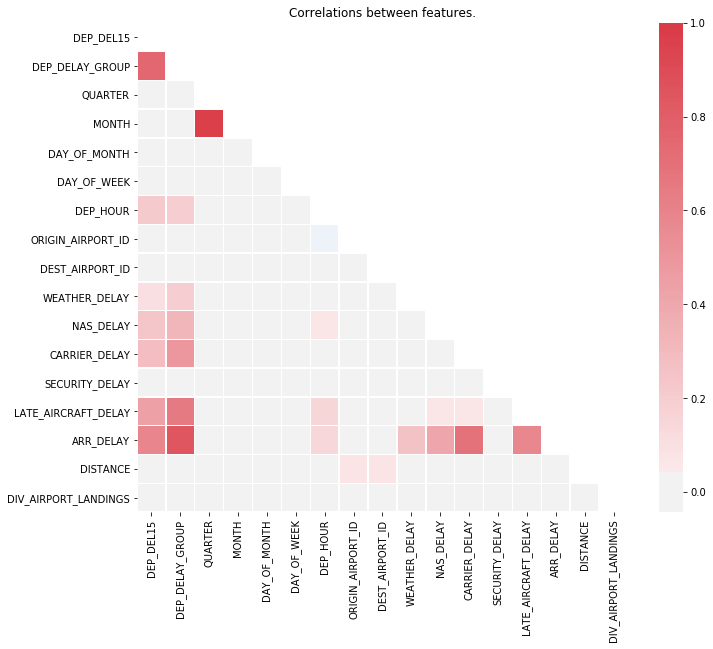

In [35]:
# plot heatmap for correlations matrix 
corr = sample_df2[FIELDS[:]].corr()
fig, ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
plt.title("Correlations between the selected features.")
display(plt.show())

- Take a look at the airline_6m data

In [37]:
airlines_6m.cache()
f'{airlines_6m.count():,}'
#display(airlines.describe())

display(airlines_6m.sample(False, 0.00001))

YEAR QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK FL_DATE OP_UNIQUE_CARRIER OP_CARRIER_AIRLINE_ID OP_CARRIER TAIL_NUM OP_CARRIER_FL_NUM ORIGIN_AIRPORT_ID ORIGIN_AIRPORT_SEQ_ID ORIGIN_CITY_MARKET_ID ORIGIN ORIGIN_CITY_NAME ORIGIN_STATE_ABR ORIGIN_STATE_FIPS ORIGIN_STATE_NM ORIGIN_WAC DEST_AIRPORT_ID DEST_AIRPORT_SEQ_ID DEST_CITY_MARKET_ID DEST DEST_CITY_NAME DEST_STATE_ABR DEST_STATE_FIPS DEST_STATE_NM DEST_WAC CRS_DEP_TIME DEP_TIME DEP_DELAY DEP_DELAY_NEW DEP_DEL15 DEP_DELAY_GROUP DEP_TIME_BLK TAXI_OUT WHEELS_OFF WHEELS_ON TAXI_IN CRS_ARR_TIME ARR_TIME ARR_DELAY ARR_DELAY_NEW ARR_DEL15 ARR_DELAY_GROUP ARR_TIME_BLK CANCELLED CANCELLATION_CODE DIVERTED CRS_ELAPSED_TIME ACTUAL_ELAPSED_TIME AIR_TIME FLIGHTS DISTANCE DISTANCE_GROUP CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY FIRST_DEP_TIME TOTAL_ADD_GTIME LONGEST_ADD_GTIME DIV_AIRPORT_LANDINGS DIV_REACHED_DEST DIV_ACTUAL_ELAPSED_TIME DIV_ARR_DELAY DIV_DISTANCE DIV1_AIRPORT DIV1_AIRPORT_ID DIV1_AIRPORT_SEQ_ID DIV1_WHEELS_ON DIV1_TOTAL_GTIME DIV1_LONGEST_GTIME DIV1_WHEELS_OFF DIV1_TAIL_NUM DIV2_AIRPORT DIV2_AIRPORT_ID DIV2_AIRPORT_SEQ_ID DIV2_WHEELS_ON DIV2_TOTAL_GTIME DIV2_LONGEST_GTIME DIV2_WHEELS_OFF DIV2_TAIL_NUM DIV3_AIRPORT DIV3_AIRPORT_ID DIV3_AIRPORT_SEQ_ID DIV3_WHEELS_ON DIV3_TOTAL_GTIME DIV3_LONGEST_GTIME DIV3_WHEELS_OFF DIV3_TAIL_NUM DIV4_AIRPORT DIV4_AIRPORT_ID DIV4_AIRPORT_SEQ_ID DIV4_WHEELS_ON DIV4_TOTAL_GTIME DIV4_LONGEST_GTIME DIV4_WHEELS_OFF DIV4_TAIL_NUM DIV5_AIRPORT DIV5_AIRPORT_ID DIV5_AIRPORT_SEQ_ID DIV5_WHEELS_ON DIV5_TOTAL_GTIME DIV5_LONGEST_GTIME DIV5_WHEELS_OFF DIV5_TAIL_NUM 2015 2 4 28 2 2015-04-28 MQ 20398 MQ N604MQ 3677 13930 1393003 30977 ORD Chicago, IL IL 17 Illinois 41 10693 1069302 30693 BNA Nashville, TN TN 47 Tennessee 54 1000 954 -6.0 0.0 0.0 -1 1000-1059 9.0 1003 1106 4.0 1128 1110 -18.0 0.0 0.0 -2 1100-1159 0.0 null 0.0 88.0 76.0 63.0 1.0 409.0 2 null null null null null null null null 0 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null

In [38]:
airlines_6m.cache()
f'{airlines_6m.count():,}'
airline_desc = airlines_6m.describe()

In [39]:
display(airline_desc)

summary DEP_DEL15 WEATHER_DELAY NAS_DELAY CARRIER_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY ORIGIN_AIRPORT_ID DEST_AIRPORT_ID DEP_TIME FL_DATE DEP_HOUR count 330286 330286 330286 330286 330286 330286 330286 330286 330286 330286 330286 mean 0.2235153775818533 1.2913656649085943 2.7035750834125576 4.267586273714296 0.004992642739928426 4.4102626208800855 11960.357260071574 12718.484446812763 1438.1361274773983 null 14.265863524339512 stddev 0.416601463080145 13.894578930817708 13.369355361111134 20.0428368419544 0.4104718212896615 20.100377096069913 1754.783348518915 1527.3612014440619 475.84308963455345 null 4.76807816750737 min 0.0 0.0 0.0 0.0 0.0 0.0 10397 10135 1 2015-01-01 0.0 max 1.0 1068.0 862.0 1221.0 69.0 728.0 13930 15919 2400 2015-06-30 24.0

In [40]:
display(airlines_6m.sample(False, 0.001).select('DEP_DELAY', 'DEP_DELAY_NEW'))

DEP_DELAY DEP_DELAY_NEW -6.0 0.0 2.0 2.0 0.0 0.0 146.0 146.0 22.0 22.0 0.0 0.0 -4.0 0.0 17.0 17.0 -2.0 0.0 0.0 0.0 -5.0 0.0 -2.0 0.0 3.0 3.0 -6.0 0.0 30.0 30.0 0.0 0.0 47.0 47.0 4.0 4.0 1.0 1.0 150.0 150.0 0.0 0.0 102.0 102.0 2.0 2.0 -4.0 0.0 -3.0 0.0 2.0 2.0 -7.0 0.0 -5.0 0.0 -6.0 0.0 2.0 2.0 50.0 50.0 72.0 72.0 0.0 0.0 -4.0 0.0 -3.0 0.0 9.0 9.0 5.0 5.0 10.0 10.0 -1.0 0.0 -4.0 0.0 -1.0 0.0 19.0 19.0 -4.0 0.0 0.0 0.0 146.0 146.0 null null 28.0 28.0 -1.0 0.0 0.0 0.0 -1.0 0.0 -2.0 0.0 -6.0 0.0 -1.0 0.0 -4.0 0.0 0.0 0.0 -1.0 0.0 21.0 21.0 18.0 18.0 -7.0 0.0 0.0 0.0 -3.0 0.0 117.0 117.0 -2.0 0.0 11.0 11.0 -2.0 0.0 24.0 24.0 -5.0 0.0 16.0 16.0 29.0 29.0 41.0 41.0 5.0 5.0 43.0 43.0 -1.0 0.0 16.0 16.0 -3.0 0.0 4.0 4.0 4.0 4.0 64.0 64.0 9.0 9.0 2.0 2.0 -4.0 0.0 23.0 23.0 -1.0 0.0 -5.0 0.0 -5.0 0.0 -5.0 0.0 34.0 34.0 14.0 14.0 24.0 24.0 -3.0 0.0 23.0 23.0 5.0 5.0 8.0 8.0 3.0 3.0 27.0 27.0 171.0 171.0 29.0 29.0 -2.0 0.0 -5.0 0.0 -2.0 0.0 -3.0 0.0 -5.0 0.0 43.0 43.0 -5.0 0.0 -4.0 0.0 17.0 17.0 9.0 9.0 0.0 0.0 39.0 39.0 13.0 13.0 -6.0 0.0 -5.0 0.0 10.0 10.0 18.0 18.0 7.0 7.0 17.0 17.0 2.0 2.0 null null -4.0 0.0 0.0 0.0 -1.0 0.0 -3.0 0.0 -3.0 0.0 1.0 1.0 -1.0 0.0 12.0 12.0 -5.0 0.0 108.0 108.0 37.0 37.0 14.0 14.0 244.0 244.0 -4.0 0.0 null null 185.0 185.0 6.0 6.0 64.0 64.0 42.0 42.0 -5.0 0.0 2.0 2.0 0.0 0.0 -3.0 0.0 -4.0 0.0 18.0 18.0 141.0 141.0 2.0 2.0 16.0 16.0 7.0 7.0 96.0 96.0 3.0 3.0 22.0 22.0 -1.0 0.0 -5.0 0.0 -5.0 0.0 16.0 16.0 178.0 178.0 -3.0 0.0 5.0 5.0 0.0 0.0 6.0 6.0 null null 0.0 0.0 44.0 44.0 1.0 1.0 17.0 17.0 1.0 1.0 -3.0 0.0 0.0 0.0 -2.0 0.0 -1.0 0.0 -6.0 0.0 11.0 11.0 7.0 7.0 4.0 4.0 -8.0 0.0 0.0 0.0 -3.0 0.0 -4.0 0.0 -5.0 0.0 -6.0 0.0 16.0 16.0 31.0 31.0 -3.0 0.0 -3.0 0.0 20.0 20.0 -5.0 0.0 -1.0 0.0 0.0 0.0 54.0 54.0 56.0 56.0 -7.0 0.0 -1.0 0.0 -4.0 0.0 30.0 30.0 -1.0 0.0 -6.0 0.0 -3.0 0.0 -4.0 0.0 -4.0 0.0 -5.0 0.0 5.0 5.0 2.0 2.0 -1.0 0.0 26.0 26.0 -1.0 0.0 -2.0 0.0 14.0 14.0 -3.0 0.0 1.0 1.0 -2.0 0.0 -5.0 0.0 10.0 10.0 -7.0 0.0 -3.0 0.0 -3.0 0.0 52.0 52.0 -4.0 0.0 -5.0 0.0 49.0 49.0 8.0 8.0 -1.0 0.0 11.0 11.0 0.0 0.0 -1.0 0.0 -5.0 0.0 -3.0 0.0 1.0 1.0 0.0 0.0 100.0 100.0 32.0 32.0 -4.0 0.0 -3.0 0.0 -10.0 0.0 20.0 20.0 24.0 24.0 -2.0 0.0 3.0 3.0 39.0 39.0 3.0 3.0 -1.0 0.0 0.0 0.0 -2.0 0.0 32.0 32.0 -2.0 0.0 -1.0 0.0 47.0 47.0 77.0 77.0 -1.0 0.0 20.0 20.0 23.0 23.0 -2.0 0.0 -2.0 0.0 72.0 72.0 -5.0 0.0 -3.0 0.0 -11.0 0.0 -2.0 0.0 2.0 2.0 5.0 5.0 66.0 66.0 0.0 0.0 -2.0 0.0 0.0 0.0 -4.0 0.0 95.0 95.0 -12.0 0.0 107.0 107.0 53.0 53.0 -7.0 0.0 0.0 0.0 8.0 8.0 -1.0 0.0 -3.0 0.0 -2.0 0.0 47.0 47.0 16.0 16.0 -4.0 0.0 68.0 68.0 16.0 16.0 4.0 4.0 3.0 3.0 4.0 4.0 -4.0 0.0 -4.0 0.0 -8.0 0.0 7.0 7.0 0.0 0.0 -13.0 0.0 -4.0 0.0 -5.0 0.0 0.0 0.0 31.0 31.0 -7.0 0.0 2.0 2.0 -3.0 0.0 -1.0 0.0 0.0 0.0 -2.0 0.0 -1.0 0.0 5.0 5.0 12.0 12.0 -2.0 0.0 68.0 68.0 -4.0 0.0 -2.0 0.0 35.0 35.0 15.0 15.0 -4.0 0.0 -5.0 0.0 142.0 142.0 -1.0 0.0 0.0 0.0 45.0 45.0 53.0 53.0 53.0 53.0 109.0 109.0 -2.0 0.0 -4.0 0.0 0.0 0.0 -7.0 0.0 3.0 3.0 -1.0 0.0 3.0 3.0 null null 13.0 13.0 -4.0 0.0 null null -1.0 0.0

While exploring the subset of cancelled flights, we noticed that for all cancelled flights, all delay attributes had null values.

ORIGINAL NOTES:

- There is no the correlations between dep_delay_new, dep_delay_group with cancellation_code/cancelled.

In [42]:
# looking at delay and cancelled flights, 
# display(airlines_6m.where(F.col('cancelled') == 1).select(potential_outcome_vars))

DEP_DELAY DEP_DELAY_NEW DEP_DEL15 DEP_DELAY_GROUP CANCELLED CANCELLATION_CODE WEATHER_DELAY NAS_DELAY null null null null 1.0 B null null null null null null 1.0 A null null null null null null 1.0 A null null null null null null 1.0 A null null null null null null 1.0 B null null null null null null 1.0 B null null null null null null 1.0 B null null null null null null 1.0 C null null null null null null 1.0 B null null null null null null 1.0 B null null null null null null 1.0 C null null null null null null 1.0 B null null null null null null 1.0 B null null 83.0 83.0 1.0 5 1.0 A null null null null null null 1.0 B null null null null null null 1.0 B null null null null null null 1.0 A null null null null null null 1.0 B null null null null null null 1.0 B null null null null null null 1.0 A null null null null null null 1.0 A null null null null null null 1.0 B null null null null null null 1.0 A null null null null null null 1.0 A null null null null null null 1.0 B null null null null null null 1.0 A null null null null null null 1.0 B null null null null null null 1.0 B null null null null null null 1.0 A null null null null null null 1.0 B null null null null null null 1.0 A null null null null null null 1.0 B null null null null null null 1.0 B null null null null null null 1.0 B null null null null null null 1.0 A null null null null null null 1.0 B null null null null null null 1.0 B null null null null null null 1.0 B null null null null null null 1.0 B null null null null null null 1.0 A null null null null null null 1.0 A null null null null null null 1.0 B null null null null null null 1.0 A null null null null null null 1.0 B null null null null null null 1.0 A null null null null null null 1.0 A null null null null null null 1.0 B null null null null null null 1.0 B null null null null null null 1.0 B null null null null null null 1.0 B null null null null null null 1.0 A null null null null null null 1.0 A null null null null null null 1.0 B null null null null null null 1.0 A null null null null null null 1.0 A null null null null null null 1.0 B null null null null null null 1.0 B null null null null null null 1.0 B null null null null null null 1.0 B null null null null null null 1.0 B null null null null null null 1.0 A null null null null null null 1.0 B null null null null null null 1.0 B null null null null null null 1.0 B null null null null null null 1.0 B null null null null null null 1.0 B null null null null null null 1.0 B null null null null null null 1.0 B null null null null null null 1.0 A null null null null null null 1.0 B null null null null null null 1.0 B null null null null null null 1.0 C null null null null null null 1.0 C null null null null null null 1.0 B null null null null null null 1.0 B null null null null null null 1.0 B null null null null null null 1.0 B null null null null null null 1.0 B null null null null null null 1.0 B null null null null null null 1.0 B null null null null null null 1.0 A null null null null null null 1.0 A null null null null null null 1.0 A null null null null null null 1.0 A null null null null null null 1.0 B null null null null null null 1.0 A null null null null null null 1.0 B null null null null null null 1.0 B null null null null null null 1.0 B null null null null null null 1.0 A null null null null null null 1.0 A null null null null null null 1.0 B null null null null null null 1.0 A null null null null null null 1.0 B null null null null null null 1.0 B null null null null null null 1.0 B null null null null null null 1.0 B null null null null null null 1.0 A null null null null null null 1.0 A null null null null null null 1.0 B null null null null null null 1.0 B null null null null null null 1.0 B null null null null null null 1.0 A null null null null null null 1.0 C null null null null null null 1.0 C null null null null null null 1.0 C null null null null null null 1.0 C null null null null null null 1.0 A null null null null null

In [43]:
# instructed not to use cancelled flight data
# Look at the causes for flight cancellations (not part of the actual model, but for EDA to understand how much overlap it has with delays; would this be different on the full set?)
#7,541 flights cancelled
#59.4% due to weather
#21.5% due to NAS
#19.1% due to carrier
#0.0% due to security
# display(airlines_6m.where(F.col('cancelled') == 1).groupBy('CANCELLATION_CODE').count().show())

+-----------------+-----+
CANCELLATION_CODE|count|
+-----------------+-----+
 B| 4477|
 C| 1619|
 A| 1445|
+-----------------+-----+

In [44]:
#potential_outcome_vars = ['DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_DELAY_GROUP', 'WEATHER_DELAY', 'NAS_DELAY']
airline_columns_tokeep = ['DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_DELAY_GROUP', 'CANCELLED', 'CANCELLATION_CODE', 'WEATHER_DELAY', 'NAS_DELAY', 'MONTH', 'DAY_OF_WEEK', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID']
airline_baseline_df = airlines_6m.where(F.col('cancelled') == 0).select(airline_columns_tokeep)

There were only 644 instances in the first half of 2015 where weather delays were observed, but the flight was not delayed more than 15 minutes.  Based on this, we determined that weather is an important factor, which led us to join weather data to our main dataset.

ORIGINAL NOTES:

- Only 644 rows in the first 6 months of 2015 when the weather delay has value but the flight did not delayed more than 15 minutes, which means weather is relatively important factor to DEP_DELAY15, we will need to join the weather data to the dataset.

In [46]:
display(airline_baseline_df.where(F.col('dep_del15') == 0).where(F.col('weather_delay') != 0))

DEP_DELAY DEP_DELAY_NEW DEP_DEL15 DEP_DELAY_GROUP CANCELLED CANCELLATION_CODE WEATHER_DELAY NAS_DELAY MONTH DAY_OF_WEEK ORIGIN_AIRPORT_ID DEST_AIRPORT_ID 10.0 10.0 0.0 0 0.0 null 10.0 12.0 6 1 13930 10423 10.0 10.0 0.0 0 0.0 null 10.0 7.0 6 1 13930 11298 10.0 10.0 0.0 0 0.0 null 2.0 93.0 6 7 13930 11298 14.0 14.0 0.0 0 0.0 null 14.0 30.0 6 2 10397 13422 6.0 6.0 0.0 0 0.0 null 6.0 9.0 6 2 10397 11995 7.0 7.0 0.0 0 0.0 null 7.0 26.0 6 2 10397 11066 12.0 12.0 0.0 0 0.0 null 12.0 29.0 6 2 10397 11721 14.0 14.0 0.0 0 0.0 null 9.0 10.0 6 3 10397 11433 11.0 11.0 0.0 0 0.0 null 11.0 10.0 6 3 10397 12478 13.0 13.0 0.0 0 0.0 null 6.0 3.0 6 4 10397 13495 7.0 7.0 0.0 0 0.0 null 7.0 9.0 6 4 10397 11057 13.0 13.0 0.0 0 0.0 null 11.0 3.0 6 2 13930 12448 8.0 8.0 0.0 0 0.0 null 8.0 8.0 6 1 13930 11423 11.0 11.0 0.0 0 0.0 null 11.0 59.0 6 6 10397 11066 14.0 14.0 0.0 0 0.0 null 14.0 30.0 6 7 13930 13244 11.0 11.0 0.0 0 0.0 null 8.0 28.0 6 6 13930 11203 6.0 6.0 0.0 0 0.0 null 6.0 16.0 6 4 13930 11042 12.0 12.0 0.0 0 0.0 null 1.0 3.0 6 2 13930 13198 14.0 14.0 0.0 0 0.0 null 14.0 40.0 6 4 13930 14771 13.0 13.0 0.0 0 0.0 null 13.0 12.0 6 7 13930 14747 8.0 8.0 0.0 0 0.0 null 8.0 28.0 6 7 13930 14107 10.0 10.0 0.0 0 0.0 null 10.0 18.0 6 1 10397 14771 7.0 7.0 0.0 0 0.0 null 11.0 0.0 6 5 13930 14771 -3.0 0.0 0.0 -1 0.0 null 17.0 0.0 6 7 13930 12892 0.0 0.0 0.0 0 0.0 null 35.0 0.0 6 1 13930 14771 10.0 10.0 0.0 0 0.0 null 4.0 6.0 6 2 10397 15304 14.0 14.0 0.0 0 0.0 null 14.0 5.0 6 6 10397 14027 12.0 12.0 0.0 0 0.0 null 12.0 3.0 6 6 10397 13204 11.0 11.0 0.0 0 0.0 null 11.0 18.0 6 6 10397 12266 10.0 10.0 0.0 0 0.0 null 8.0 29.0 6 6 10397 14492 14.0 14.0 0.0 0 0.0 null 14.0 14.0 6 6 10397 12889 9.0 9.0 0.0 0 0.0 null 3.0 10.0 6 6 10397 13303 12.0 12.0 0.0 0 0.0 null 12.0 12.0 6 6 10397 13204 12.0 12.0 0.0 0 0.0 null 3.0 3.0 6 6 10397 14100 14.0 14.0 0.0 0 0.0 null 14.0 24.0 6 1 13930 10792 7.0 7.0 0.0 0 0.0 null 7.0 12.0 6 4 10397 12953 10.0 10.0 0.0 0 0.0 null 10.0 13.0 6 4 13930 13851 1.0 1.0 0.0 0 0.0 null 1.0 44.0 6 1 13930 13485 13.0 13.0 0.0 0 0.0 null 13.0 39.0 6 6 13930 13851 2.0 2.0 0.0 0 0.0 null 2.0 37.0 6 4 13930 10792 9.0 9.0 0.0 0 0.0 null 9.0 7.0 6 1 13930 11109 14.0 14.0 0.0 0 0.0 null 14.0 4.0 6 6 13930 11823 13.0 13.0 0.0 0 0.0 null 13.0 3.0 6 3 10397 14107 13.0 13.0 0.0 0 0.0 null 13.0 115.0 6 1 13930 12953 7.0 7.0 0.0 0 0.0 null 7.0 18.0 6 6 13930 12889 14.0 14.0 0.0 0 0.0 null 14.0 4.0 6 4 10397 12892 9.0 9.0 0.0 0 0.0 null 9.0 22.0 6 2 10397 10821 10.0 10.0 0.0 0 0.0 null 10.0 11.0 6 2 10397 10431 8.0 8.0 0.0 0 0.0 null 8.0 23.0 6 2 10397 12339 12.0 12.0 0.0 0 0.0 null 12.0 23.0 6 2 10397 15370 13.0 13.0 0.0 0 0.0 null 13.0 35.0 6 2 10397 13230 8.0 8.0 0.0 0 0.0 null 8.0 18.0 6 2 10397 13204 9.0 9.0 0.0 0 0.0 null 9.0 21.0 6 2 10397 14683 13.0 13.0 0.0 0 0.0 null 10.0 6.0 6 1 13930 11433 9.0 9.0 0.0 0 0.0 null 6.0 16.0 6 6 10397 12953 11.0 11.0 0.0 0 0.0 null 11.0 7.0 2 7 13930 12953 9.0 9.0 0.0 0 0.0 null 9.0 15.0 2 3 13930 14747 6.0 6.0 0.0 0 0.0 null 6.0 9.0 2 5 13930 10721 6.0 6.0 0.0 0 0.0 null 6.0 19.0 2 1 13930 14771 6.0 6.0 0.0 0 0.0 null 6.0 21.0 2 5 13930 14908 14.0 14.0 0.0 0 0.0 null 14.0 17.0 2 4 13930 14027 7.0 7.0 0.0 0 0.0 null 7.0 15.0 2 7 10397 13871 10.0 10.0 0.0 0 0.0 null 2.0 15.0 2 2 10397 14307 13.0 13.0 0.0 0 0.0 null 13.0 10.0 2 2 10397 14307 9.0 9.0 0.0 0 0.0 null 9.0 41.0 2 4 13930 10397 10.0 10.0 0.0 0 0.0 null 6.0 5.0 2 3 13930 13487 5.0 5.0 0.0 0 0.0 null 5.0 15.0 2 3 13930 11057 9.0 9.0 0.0 0 0.0 null 9.0 6.0 2 2 10397 15016 12.0 12.0 0.0 0 0.0 null 12.0 5.0 2 2 10397 11540 12.0 12.0 0.0 0 0.0 null 12.0 9.0 2 2 10397 15370 9.0 9.0 0.0 0 0.0 null 9.0 44.0 2 5 13930 11433 14.0 14.0 0.0 0 0.0 null 1.0 7.0 2 6 13930 12945 9.0 9.0 0.0 0 0.0 null 9.0 55.0 2 5 13930 12339 9.0 9.0 0.0 0 0.0 null 3.0 47.0 2 7 13930 11267 10.0 10.0 0.0 0 0.0 null 6.0 11.0 2 1 13930 11267 6.0 6.0 0.0 0 0.0 null 6.0 17.0 2 5 13930 15048 14.0 14.0 0.0 0 0.0 null 14.0 3.0 2 5 13930 15048 11.0 11.0 0.0 0 0.0 null 11.0 7.0 2 4 13930 1119

#### Flight table transformation

For the baseline, we chose to drop the cancelled flight form the baseline, with the possibility of reintroducing that data in a subsequent stage.  Based on feedback, we dropped the latter idea.  To transform the flight table, we separated the `DEP_TIME` attributes by hour for the join process.  We avoided joining data from two hours prior, as we assume that weather information will be available for the departure flight when using the model to make a prediction in real time.

ORIGINAL NOTES:

- drop cancelled flight for baseline 
- Seperate DEP_TIME into Hour for join. As we explained before, we do not want to join for 2 hours before, since we are not doing weather prediction, we assume the weather information will be available for the departure flight in real life.

In [48]:
#airline_columns_tokeep = ['DEP_DEL15', 'WEATHER_DELAY', 'NAS_DELAY', 'CARRIER_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'MONTH', 'DAY_OF_WEEK', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'DEP_TIME', 'FL_DATE', "DEP_HOUR"]
airline_columns_tokeep = ['DEP_DEL15', 'WEATHER_DELAY', 'NAS_DELAY', 'CARRIER_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'DEP_TIME', 'FL_DATE', "DEP_HOUR"]

# load airlines data
airlines = spark.read.option("header", "true").parquet(f"dbfs:/mnt/mids-w261/data/datasets_final_project/parquet_airlines_data_6m/part-*.parquet")

# Seperate DEP_TIME into Hour for join (We might want to use TimeStamp values with date to join for 2 hours before)
airlines = airlines.withColumn("DEP_HOUR", F.bround('DEP_TIME', -2)/100)

# drop cancelled flight for baseline 
airlines = airlines.where(F.col('cancelled') == 0).select(airline_columns_tokeep)

# replace null value by zeros
airlines = airlines.withColumn('NAS_DELAY', F.when(airlines['NAS_DELAY'].isNull(), 0).otherwise(airlines['NAS_DELAY']) )
airlines = airlines.withColumn('WEATHER_DELAY', F.when(airlines['WEATHER_DELAY'].isNull(), 0).otherwise(airlines['WEATHER_DELAY']) )
airlines = airlines.withColumn('SECURITY_DELAY', F.when(airlines['SECURITY_DELAY'].isNull(), 0).otherwise(airlines['SECURITY_DELAY']) )
airlines = airlines.withColumn('LATE_AIRCRAFT_DELAY', F.when(airlines['LATE_AIRCRAFT_DELAY'].isNull(), 0).otherwise(airlines['LATE_AIRCRAFT_DELAY']) )
airlines = airlines.withColumn('CARRIER_DELAY', F.when(airlines['CARRIER_DELAY'].isNull(), 0).otherwise(airlines['CARRIER_DELAY']) )

#display(airlines.sample(False, 0.0001))

#### EDA Stations

- I do not think we are using this data. not sure what was the intention? maybe to use based on the name? 
- So we got another CSV file that contains geo coordinate information. Notice that latitude and longitude are slight different for the station. so we average the coordinate value per airport ID

[KP NOTE: Need to confirm whether these were used in the end]

In [50]:
stations = spark.read.option("header", "true").csv("dbfs:/mnt/mids-w261/data/DEMO8/gsod/stations.csv.gz")

stations.cache()
f'{stations.count():,}'

display(stations.sample(False, 0.001))

usaf wban name country state call lat lon elev begin end 152005 99999 ARAD RO null null 46.167 21.317 +0108.0 19751202 19901120 350830 99999 AKSU KZ null null 52.467 71.983 +0290.0 19590101 20020609 615100 99999 SELIBABY MR null null 15.233 -12.167 +0060.0 20041119 20150804 623690 99999 BAHTIM EG null null 30.133 31.25 +0016.0 20010924 20020601 675890 99999 DWANGWA MI null null -12.483 34.083 +0489.0 19730106 20160125 804380 99999 ALBERTO CARNEVALLI VE null SVMD 8.582 -71.161 +1526.1 19730206 20181206 949999 00003 HALLS CREEK POST OFFICE AS null null -18.23 127.67 +0409.7 19571130 19731212 999999 34061 EVREUX FR null LFOE 49.017 1.233 +0141.1 19541022 19670608 151910 99999 BOGUS ROMANIAN RO null null null null null 19860603 20021222 725980 99999 null US null null null null null 19730101 19760305 589280 99999 ZHANG-PING CH null null 25.3 117.4 +0000.0 19740421 19851011 030521 99999 SHIN UK null null 57.95 -4.417 +0007.0 20070307 20070307 040040 99999 GUFUSKALAR IC null null 64.9 -23.933 +0007.0 19490101 20020405 475670 99999 KASUMINOME (JASDF) JA null RJSU 38.233 140.917 +0010.0 19730103 20140701 726037 99999 CAPE NEDDICK COAST GUARD LIGH US null null 43.17 -70.6 +0012.0 19750911 19871119 949999 00008 DERBY AIRPORT AS null null -17.37 123.67 +0012.0 19720417 19811130 105910 99999 LICHTENHAIN-MITTELD GM null null 50.933 14.217 +0300.0 19911101 20030816 724768 99999 GREELEY WELD CO US CO KGXY 40.437 -104.633 +1432.0 19880105 20051231 864500 99999 YOUNG UY null null -32.683 -57.633 +0080.0 19780801 20190302 024640 99999 BROMMA SW null ESSB 59.354 17.942 +0014.3 19310101 20190303 071040 99999 POINTE DE TOULINGUET FR null null 48.283 -4.633 +0036.0 19831208 20190303 319610 99999 TIMIRYAZEVSKIJ RS null null 43.883 131.967 +0037.0 19590718 20190303 406570 99999 HELLA IZ null null 32.45 44.45 +0027.0 19881120 20190303 415360 99999 BALAKOT PK null null 34.383 73.35 +0981.0 19980301 20190303 425120 99999 SHILLONG ARPT/UMROI ARPT IN null VEBI 25.7 91.983 +0891.2 20151208 20190303 603530 99999 JIJEL-PORT AG null null 36.817 5.883 +0006.0 19951101 20190303 702120 26646 CAPE ROMANZOF LRRS ARPT US AK PACZ 61.783 -166.033 +0146.0 20060101 20190304 725625 94040 MC COOK MUNICIPAL AIRPORT US NE KMCK 40.206 -100.591 +0771.1 20060101 20190304 724586 03919 SALINA MUNICIPAL AIRPORT US KS KSLN 38.8 -97.65 +0386.8 19730101 20190305

In [51]:
# import lat/lon
# 193497807_T_MASTER_CORD.csv 
Airport_DF = spark.read.csv(MASTER_CORD_PATH, header="true", inferSchema="true")
Airport_DF.show(5)

keep_columns = ['AIRPORT_ID', 'DISPLAY_AIRPORT_NAME', 'LATITUDE', 'LONGITUDE']
Airport_DF = Airport_DF.select(*keep_columns)
display(Airport_DF.where(F.col('AIRPORT_ID')==13930).take(5))
Airport_DF.select('AIRPORT_ID').count()

AIRPORT_ID DISPLAY_AIRPORT_NAME LATITUDE LONGITUDE 13930 Chicago O'Hare International 41.97805556 -87.90611111 13930 Chicago O'Hare International 41.98166667 -87.90666667 13930 Chicago O'Hare International 41.97944444 -87.9075 13930 Chicago O'Hare International 41.97722222 -87.90805556 13930 Chicago O'Hare International 41.98166667 -87.90666667

#### EDA Weather dataset

We then turned to conducting EDA on the weather dataset.  For the purposes of this stage, we used the full 2015 weather station data.  This file contained 116 million records, encompassing reports from 12,794 stations.  We saw that this dataset included several attributes that might be useful for joining it to the airlines dataset - namely, time, latitude, longitude, elevation, and name.

ORIGINAL NOTES:

##### size
- For EDA, we only used the full year of 2015 weather station data
- 6 months data would be approximately half `509 millions` records assuming half of 1 year data, `116,341,048` records.

##### weather stations basic info
- A total of 12794 weather stations in year 2015
- weather stations has basic information of *time*, *latitude* and *longitude*, *elevation*, *name*, which could be helpful for joining to airline dataset

In [53]:
# Load the data of 2015 weather
parquet_path = ["dbfs:/mnt/mids-w261/data/datasets_final_project/weather_data/weather2015a.parquet"]
weather_eda = spark.read.option("header", "true").parquet(*parquet_path)

In [54]:
# Count of each column
weather_eda_col = weather_eda.select("STATION").count()
print("Total Columns:", weather_eda_col)

# Unique value of each column
for col in weather_eda.columns:
  print(col,weather_eda.select(col).distinct().count())

Total Columns: 116341048
STATION 12794
DATE 525468
SOURCE 7
LATITUDE 9115
LONGITUDE 10796
ELEVATION 4749
NAME 12617
REPORT_TYPE 13
CALL_SIGN 2168
QUALITY_CONTROL 2
WND 120845
CIG 2750
VIS 5775
TMP 4292
DEW 3735
SLP 4488
AW1 184
GA1 19567
GA2 13682
GA3 7723
GA4 2120
GE1 2
GF1 18989
KA1 7425
KA2 6307
MA1 207595
MD1 39540
MW1 177
MW2 117
OC1 732
OD1 7341
OD2 572
REM 97506248
EQD 145548
AW2 143
AX4 8
GD1 2429
AW5 17
GN1 60706
AJ1 898
AW3 102
MK1 11032
KA4 671
GG3 17
AN1 551
RH1 94
AU5 6
HL1 31
OB1 487643
AT8 17
AW7 2
AZ1 57
CH1 553479
RH3 99
GK1 219
IB1 7778
AX1 19
CT1 2188
AK1 588
CN2 91230
OE1 96860
MW5 5
AO1 141
KA3 1083
AA3 2753
CR1 19
CF2 1608
KB2 4256
GM1 29683
AT5 44
AY2 51
MW6 2
MG1 94710
AH6 9835
AU2 213
GD2 1708
AW4 39
MF1 39534
AA1 10342
AH2 9817
AH3 9821
OE3 806
AT6 33
AL2 14
AL3 1
AX5 4
IB2 24273
AI3 9837
CV3 43196
WA1 50
GH1 595485
KF1 907
CU2 263
CT3 2294
SA1 391
AU1 327
KD2 2531
AI5 9846
GO1 27830
GD3 1184
CG3 12780
AI1 9839
AL1 78
AW6 7
MW4 27
AX6 3
CV1 43037
ME1 4778
KC2 5962
CN1 3541
UA1 211
GD5 1
UG2 60
AT3 70
AT4 55
GJ1 967
MV1 14
GA5 266
CT2 2754
CG2 13660
ED1 1004
AE1 4197
CO1 7
KE1 2355
KB1 4253
AI4 9842
MW3 81
KG2 115
AA2 7014
AX2 19
AY1 51
RH2 99
OE2 91587
CU3 202
MH1 8212
AM1 859
AU4 28
GA6 45
KG1 110
AU3 81
AT7 21
KD1 4956
GL1 1
IA1 24
GG2 45
OD3 99
UG1 514
CB1 237
AI6 9821
CI1 615398
CV2 44820
AZ2 54
AD1 9038
AH1 9782
WD1 26
AA4 95
KC1 6218
IA2 428
CF3 1210
AI2 9843
AT1 86
GD4 498
AX3 17
AH4 9832
KB3 4705
CU1 195
CN4 162
AT2 77
CG1 13108
CF1 1362
GG1 190
MV2 3
CW1 543176
GG4 1
AB1 4083
AH5 9838
CN3 1743

##### Variable Description (https://www.ncei.noaa.gov/data/global-hourly/doc/isd-format-document.pdf)
- According to the variable description, the variables are non-weather related: 
  1. __*report_type*__ (POS42- 46)is only related to the type of geophysical surface observation. For example:FM-12 meansSYNOP Report of surface observation form a fixed land station)
  2. __*call_sign*__ (POS 52-56) means if the weather statoin is a Fixed Weather Station
  3. __*quality_control*__ (POS 57-60) only represents the type of quality control to specific row of data
  4. __*AW1 - AW4*__ signifies the reporting of present weather
  5. __*MW1-MW7*__ signifies the reporting of present weather
  6. __*REM*__ =  Remarks Data Section
  7. __*EQD*__ = Element Quality Data
  8. __*AX1_AX6*__ signifies the reporting of past weather 
  9. __*GD1_GD6*__ denotes the availability of a SKY-COVER-SUMMATION-STATE
  10. __*AT1-AT8*__ Source data: mannualy or automated sensors
  ...
- The weather related variables: (more detialed expalination will be provided in section of __predictors__)
  1. __*WND*__ means wind, which includes wind direction, wind type, wind speed, speed quality code
  2. __*CIG*__ means celling height dimension, which includes quality code, determination code, 'Ceiling and Visibility Okay' (CAVOK) condition
  3. __*VIS*__ represents visibility oberservations, which includes distance in meters, distance quality code, variablity code and quality variablility code
  4. __*TEP*__ represents air temperature, which includes air temperature in celsius, and quality code
  5. __*DEW*__ represnets dew point temperature and dew point quality code
  6. __*SLP*__ represents sea level pressure and its quality code
  7. __*GA1-GA4*__ represents __sky cover layer coverage code__, coverage quality code, base height dimension, height quality code
  8. __*GE1*__ and __*GF1*__ represents sky condition observation identifier, all categorical data
  9. __*KA1-KA4*__ represents extreme air temperature identifier, which includes period quantity in hours, code, air temperature in celsius and quality code; __*KC1-KC2, KE1*__ Extreme air temperature by month; __*CV1-CV2*__ Extreme air temperature by hour;
  10. __*MA1*__ Atmospheric pressure observation; __*MD1*__ Atmospheric pressure change; __*MK1*__ Atmospheric pressure observation for the month
  11. __*OC1*__  denotes the start of a WIND-GUST-OBSERVATION data; __*OD1 - OD3*__ denotes the start of a SUPPLEMENTARY-WIND-OBSERVATION
  12. __*GN1*__ indicates an observation of solar radiation data; __*GK1*__ sunshine quality
  13. __*AJ1*__ Snow Depth Data; __*AN1*__ Snow Accumulation Monthly Total; __*AK1*__ Monthly Maximum Depth of Snow
  14. __*GG1-GG6*__ represents a BELOW-STATION-CLOUD-LAYER
  15. __*RH1-RH3*__ denotes the start of a RELATIVE-HUMIDITY 
  16. __*CH1, CH2*__ indicates Hourly RH and Temperature 
  17. __*AU1-AU4*__ indicates Present weather observation intensity code, descriptor code, precipitation code, __obscuration code__. 
  18. __*AZ1, AZ2*__ indicates Past weather observation condition code, period etc.
  19. __*OB1, OB2*__ Hourly wind section identifier
  20. __*IB1*__ Hourly surface temperature
  21. __*CT1-CT3*__ Average air temperature, quality code, quality flag
  22. __*OE1-OE3*__ summary of the day wind observation
  23. __*AO1-AO4*__ __Liquid Precipitation__ quantity in minutes, depth, condition, and quality code; __*AA1-AA4*__ __Liquid Precipitation__ quantity in hours, depth, condition, and quality code
  ...
- Unknown or uncategorized variables:
  1. __*HL1*__
  2. __*AW7*__
  ...

In [56]:
# Display the Data
display(weather_eda)

STATION DATE SOURCE LATITUDE LONGITUDE ELEVATION NAME REPORT_TYPE CALL_SIGN QUALITY_CONTROL WND CIG VIS TMP DEW SLP AW1 GA1 GA2 GA3 GA4 GE1 GF1 KA1 KA2 MA1 MD1 MW1 MW2 OC1 OD1 OD2 REM EQD AW2 AX4 GD1 AW5 GN1 AJ1 AW3 MK1 KA4 GG3 AN1 RH1 AU5 HL1 OB1 AT8 AW7 AZ1 CH1 RH3 GK1 IB1 AX1 CT1 AK1 CN2 OE1 MW5 AO1 KA3 AA3 CR1 CF2 KB2 GM1 AT5 AY2 MW6 MG1 AH6 AU2 GD2 AW4 MF1 AA1 AH2 AH3 OE3 AT6 AL2 AL3 AX5 IB2 AI3 CV3 WA1 GH1 KF1 CU2 CT3 SA1 AU1 KD2 AI5 GO1 GD3 CG3 AI1 AL1 AW6 MW4 AX6 CV1 ME1 KC2 CN1 UA1 GD5 UG2 AT3 AT4 GJ1 MV1 GA5 CT2 CG2 ED1 AE1 CO1 KE1 KB1 AI4 MW3 KG2 AA2 AX2 AY1 RH2 OE2 CU3 MH1 AM1 AU4 GA6 KG1 AU3 AT7 KD1 GL1 IA1 GG2 OD3 UG1 CB1 AI6 CI1 CV2 AZ2 AD1 AH1 WD1 AA4 KC1 IA2 CF3 AI2 AT1 GD4 AX3 AH4 KB3 CU1 CN4 AT2 CG1 CF1 GG1 MV2 CW1 GG4 AB1 AH5 CN3 3809099999 2015-01-01T00:00:00.000+0000 4 50.086092 -5.255711 81.38 CULDROSE, UK FM-12 99999 V020 200,1,N,0077,1 00240,1,C,N 008000,1,9,9 +0113,1 +0099,1 10306,1 01,1,+00180,1,07,1 05,1,+00240,1,07,1 08,1,+00360,1,07,1 9,AGL ,+99999,+99999 08,99,1,01,1,99,9,00180,1,99,9,99,9 99999,9,10213,1 3,1,002,1,+999,9 51,1 3,99,0144,1,999 4,99,0134,1,999 SYN10603809 11358 82015 10113 20099 30213 40306 53002 69901 75165 887// 333 81706 85708 88712 90710 91128 91026= 5,1,02,1 06,0000,2,1 6,1,02,1 3809099999 2015-01-01T00:50:00.000+0000 4 50.086092 -5.255711 81.38 CULDROSE, UK FM-15 99999 V020 210,1,N,0077,1 00183,1,C,N 008000,1,9,9 +0110,1 +0100,1 99999,9 02,1,+00122,1,99,9 04,1,+00183,1,99,9 08,1,+00305,1,99,9 9,AGL ,+99999,+99999 99,99,9,02,1,99,9,00122,1,99,9,99,9 10290,1,99999,9 51,1 MET079METAR EGDR 010050Z 21015KT 8000 -DZ FEW004 SCT006 OVC010 11/10 Q1029 YLO1= 3809099999 2015-01-01T01:00:00.000+0000 4 50.086092 -5.255711 81.38 CULDROSE, UK FM-12 99999 V020 210,1,N,0077,1 00300,1,9,N 008000,1,9,9 +0113,1 +0101,1 10300,1 01,1,+00120,1,07,1 03,1,+00180,1,07,1 08,1,+00300,1,07,1 9,AGL ,+99999,+99999 08,99,1,01,1,99,9,00120,1,99,9,99,9 99999,9,10206,1 8,1,004,1,+999,9 51,1 3,99,0134,1,999 SYN09403809 41258 82115 10113 20101 30206 40300 58004 75155 887// 333 81704 83706 88710 90710 91126= 5,1,02,1 5,1,02,1 3809099999 2015-01-01T01:50:00.000+0000 4 50.086092 -5.255711 81.38 CULDROSE, UK FM-15 99999 V020 200,1,N,0082,1 00244,1,9,N 008000,1,9,9 +0120,1 +0100,1 99999,9 04,1,+00183,1,99,9 07,1,+00244,1,99,9 08,1,+00305,1,99,9 9,AGL ,+99999,+99999 99,99,9,04,1,99,9,00183,1,99,9,99,9 10290,1,99999,9 05,1 0144,1 MET086METAR EGDR 010150Z 20016G28KT 8000 HZ SCT006 BKN008 OVC010 12/10 Q1029 REDZ YLO1= 3809099999 2015-01-01T02:00:00.000+0000 4 50.086092 -5.255711 81.38 CULDROSE, UK FM-12 99999 V020 200,1,N,0082,1 00240,1,C,N 008000,1,9,9 +0115,1 +0100,1 10294,1 03,1,+00180,1,07,1 05,1,+00240,1,07,1 08,1,+00300,1,07,1 9,AGL ,+99999,+99999 08,99,1,03,1,99,9,00180,1,99,9,99,9 99999,9,10201,1 8,1,008,1,+999,9 20,1 3,99,0149,1,999 4,99,0144,1,999 SYN10003809 41358 82016 10115 20100 30201 40294 58008 72052 886// 333 83706 85708 88710 90710 91129 91028= 2,1,02,1 5,1,02,1 3809099999 2015-01-01T02:50:00.000+0000 4 50.086092 -5.255711 81.38 CULDROSE, UK FM-15 99999 V020 210,1,N,0093,1 00122,1,9,N 006000,1,9,9 +0110,1 +0110,1 99999,9 02,1,+00061,1,99,9 07,1,+00122,1,99,9 08,1,+00213,1,99,9 9,AGL ,+99999,+99999 99,99,9,02,1,99,9,00061,1,99,9,99,9 10290,1,99999,9 51,1 MET079METAR EGDR 010250Z 21018KT 6000 -DZ FEW002 BKN004 OVC007 11/11 Q1029 YLO2= 3809099999 2015-01-01T03:00:00.000+0000 4 50.086092 -5.255711 81.38 CULDROSE, UK FM-12 99999 V020 210,1,N,0093,1 00120,1,C,N 006000,1,9,9 +0111,1 +0106,1 10296,1 01,1,+00060,1,07,1 05,1,+00120,1,07,1 08,1,+00210,1,07,1 9,AGL ,+99999,+99999 08,99,1,01,1,99,9,00060,1,99,9,99,9 99999,9,10203,1 5,1,010,1,+999,9 50,1 3,99,0144,1,999 SYN09403809 41156 82118 10111 20106 30203 40296 55010 75052 887// 333 81702 85704 88707 90710 91128= 2,1,02,1 5,1,02,1 3809099999 2015-01-01T03:50:00.000+0000 4 50.086092 -5.255711 81.38 CULDROSE, UK FM-15 99999 V020 200,1,N,0082,1 00122,1,9,N 006000,1,9,9 +0110,1 +0110,1 99999,9 02,1,+00061,1,99,9 07,1,+00122,1,99,9 08,1,+00183,1,99,9 9,AGL ,+99999,+

The key findings coming out of the weather dataset can be summarized as follows:

- It has has temporal and geospatial attributes which can be used to join it to the airline dataset
- A large number of columns are related to weather reporting rather than the parameters of the weather itself (i.e. a lot of what's available is metadata)
- A lot of the features are extremely sparse, either will null values or duplicated values
- Broadly speaking, the weather dataset can be broken down into eight categories:
  1. Wind （WND)
  2. Ceiling Height (CIG, GA1-GA4)
  3. Air Temperature (TMP)
  4. Visibility (VIS, AU1-AU4)
  5. Air Pressure (SLP)
  6. Precipitation <Dew Point, Relative Humidity, Snow Depth> (AA1 - AA4， AJ1)
  7. Solar (GN1)
  8. General Weather Code (AU1 to AU4)

ORIGINAL NOTES:

##### Findings from weather data
- The weather dataset has time, lat/lon information which can be used for joining to the airline dataset
- The weather dataset has large amount columns related to weather reporting instead of weather parameters
- The weather dataset has many columns are quite sparse or with quite a lot of duplicated values. __But why 0?? -Taeil__
- The weather dataset weather infor seems can be seperate into 8 categories: 
  1. Wind （WND)
  2. Ceiling Height (CIG, GA1-GA4)
  3. Air Temperature (TMP)
  4. Visibility (VIS, AU1-AU4)
  5. Air Pressure (SLP)
  6. Precipitation <Dew Point, Relative Humidity, Snow Depth> (AA1 - AA4， AJ1)
  7. Solar (GN1)
  8. General Weather Code (AU1 to AU4)
  
- Most of columns are not NULL but space strings, which makes hard for interpolation

In [58]:
# Count completeness of the data sample
print('DATE', weather_eda.filter(weather_eda.DATE.isNotNull()).count())

# Check for Visibility and General Code AU1 to AU4
def count_not_null(c, nan_as_null=False):
    """Use conversion between boolean and integer
    - False -> 0
    - True ->  1
    """
    pred = F.col(c).isNotNull() & (~F.isnan(c) if nan_as_null else F.lit(True))
    return F.sum(pred.cast("integer")).alias(c)

weather_eda.agg(*[count_not_null(c) for c in ['AU1','AU2','AU3','AU4']]).show()
# for col in weather_eda.columns:
#   print(col, weather_eda.filter(weather_eda.col.isNotNull()).count())

DATE 116341048
+---------+---------+---------+---------+
 AU1| AU2| AU3| AU4|
+---------+---------+---------+---------+
116341048|116341048|116341048|116341048|
+---------+---------+---------+---------+

In [59]:
# Count percentage of completeness of the whole dataset
weather_eda_agg = weather_eda.agg(*[F.count(F.when(F.isnull(c), c)).alias(c) for c in weather_eda.columns])
# for col in weather_eda.columns:
#   print(col,weather_eda.where(F.col(col).isNull()).count()/weather_eda_col)
display(weather_eda_agg)

STATION DATE SOURCE LATITUDE LONGITUDE ELEVATION NAME REPORT_TYPE CALL_SIGN QUALITY_CONTROL WND CIG VIS TMP DEW SLP AW1 GA1 GA2 GA3 GA4 GE1 GF1 KA1 KA2 MA1 MD1 MW1 MW2 OC1 OD1 OD2 REM EQD AW2 AX4 GD1 AW5 GN1 AJ1 AW3 MK1 KA4 GG3 AN1 RH1 AU5 HL1 OB1 AT8 AW7 AZ1 CH1 RH3 GK1 IB1 AX1 CT1 AK1 CN2 OE1 MW5 AO1 KA3 AA3 CR1 CF2 KB2 GM1 AT5 AY2 MW6 MG1 AH6 AU2 GD2 AW4 MF1 AA1 AH2 AH3 OE3 AT6 AL2 AL3 AX5 IB2 AI3 CV3 WA1 GH1 KF1 CU2 CT3 SA1 AU1 KD2 AI5 GO1 GD3 CG3 AI1 AL1 AW6 MW4 AX6 CV1 ME1 KC2 CN1 UA1 GD5 UG2 AT3 AT4 GJ1 MV1 GA5 CT2 CG2 ED1 AE1 CO1 KE1 KB1 AI4 MW3 KG2 AA2 AX2 AY1 RH2 OE2 CU3 MH1 AM1 AU4 GA6 KG1 AU3 AT7 KD1 GL1 IA1 GG2 OD3 UG1 CB1 AI6 CI1 CV2 AZ2 AD1 AH1 WD1 AA4 KC1 IA2 CF3 AI2 AT1 GD4 AX3 AH4 KB3 CU1 CN4 AT2 CG1 CF1 GG1 MV2 CW1 GG4 AB1 AH5 CN3 716317 0 16152629 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [60]:
# Check for Ceiling Height GA1 to GA4 
for col in ['GA1','GA2','GA3','GA4']:
  weather_eda.select(col).distinct().show(4)
  
# sky cover layer coverage code, coverage quality code, base height dimension, height quality code

+------------------+
 GA1|
+------------------+
07,1,+00810,1,99,9|
02,1,+07200,1,99,9|
08,1,+00390,1,07,1|
04,1,+00360,1,06,1|
+------------------+
only showing top 4 rows

+------------------+
 GA2|
+------------------+
07,1,+00810,1,99,9|
02,1,+01097,1,99,9|
06,1,+06300,1,02,1|
08,1,+05400,1,02,1|
+------------------+
only showing top 4 rows

+------------------+
 GA3|
+------------------+
03,1,+01500,1,06,1|
07,1,+00810,1,99,9|
08,5,+00579,5,99,9|
04,5,+01341,5,99,9|
+------------------+
only showing top 4 rows

+------------------+
 GA4|
+------------------+
07,1,+00810,1,99,9|
07,1,+01470,1,99,9|
08,1,+04572,1,99,9|
07,1,+09144,1,99,9|
+------------------+
only showing top 4 rows

In [61]:
# Check for Ceiling Height GA1 to GA4 
for col in ['AU1','AU2','AU3','AU4']:
  weather_eda.select(col).distinct().show(4)

+--------------+
 AU1|
+--------------+
2,5,03,0,0,1,5|
0,8,00,0,0,2,U|
4,7,00,0,0,1,5|
1,0,03,0,0,1,6|
+--------------+
only showing top 4 rows

+--------------+
 AU2|
+--------------+
2,5,03,0,0,1,5|
4,7,00,0,0,1,5|
0,0,00,1,0,3,5|
0,0,00,0,0,1,7|
+--------------+
only showing top 4 rows

+--------------+
 AU3|
+--------------+
2,5,03,0,0,1,5|
4,7,00,0,0,1,5|
0,0,00,0,0,1,7|
0,0,00,1,0,3,5|
+--------------+
only showing top 4 rows

+--------------+
 AU4|
+--------------+
2,5,03,0,0,1,5|
4,7,00,0,0,1,5|
0,0,00,0,0,1,7|
0,8,00,2,0,1,5|
+--------------+
only showing top 4 rows

In [62]:
# Check for Precipitation AA1 to AA4
for col in ['AA1','AA2','AA3','AA4']:
  weather_eda.select(col).distinct().show(4)

+-----------+
 AA1|
+-----------+
03,0006,3,1|
03,0110,3,1|
00,0240,3,1|
15,0070,3,1|
+-----------+
only showing top 4 rows

+-----------+
 AA2|
+-----------+
24,9999,1,9|
24,0108,3,2|
24,0036,3,2|
24,0018,9,1|
+-----------+
only showing top 4 rows

+-----------+
 AA3|
+-----------+
24,9999,1,9|
24,0108,3,2|
24,0167,3,1|
24,0036,3,2|
+-----------+
only showing top 4 rows

+-----------+
 AA4|
+-----------+
99,0172,3,1|
99,0108,3,1|
99,0167,3,1|
99,0064,3,1|
+-----------+
only showing top 4 rows

In [63]:
# Solar data
weather_eda.select('GN1').distinct().show(4)

+--------------------+
 GN1|
+--------------------+
0060,0000,1,0240,...|
0060,0048,1,0270,...|
0060,0000,1,0266,...|
0060,0000,1,0290,...|
+--------------------+
only showing top 4 rows

As part of the EDA, we attempted to impute the missing values by using Pandas, which required conversion of the data type.  From there, we tried to determine if there was sufficient non-missing data records to allow us to fill in the gaps between them.

ORIGINAL NOTES:

##### Missing value interpolation
- Convert to pandas dataframe sample and see if we can interpolate the missing values

In [65]:
# Making a sample set of the full wather_eda set to conduct EDA 
weather_sample = weather_eda.sample(False, 0.001, 42)
print(weather_sample.count())
weather_sample_df = weather_sample.toPandas()

# Get the related features
weather_columns_tokeep = ['WND', 'CIG', 'GA1','GA2','GA3','GA4', 'TMP', 'VIS', 'AU1', 'AU2', 'AU3','AU4', 'SLP', 'AA1','AA2', 'AA3', 'AA4', 'AJ1', 'GN1']
weather_sample_df2 = weather_sample_df[weather_columns_tokeep]

116487

In [66]:
weather_sample_df2.head()

WND 
 CIG 
 GA1 
 GA2 
 GA3 
 GA4 
 TMP 
 VIS 
 AU1 
 AU2 
 AU3 
 AU4 
 SLP 
 AA1 
 AA2 
 AA3 
 AA4 
 AJ1 
 GN1 
 
 
 
 
 0 
 260,1,N,0036,1 
 00900,1,9,N 
 03,1,+00450,1,07,1 
 07,1,+00900,1,06,1 
 
 
 +0136,1 
 014000,1,9,9 
 
 
 
 
 10193,1 
 
 
 
 
 
 
 
 
 1 
 190,1,N,0010,1 
 07620,1,9,N 
 02,1,+01158,1,99,9 
 07,1,+07620,1,99,9 
 
 
 +0080,1 
 009999,1,9,9 
 
 
 
 
 99999,9 
 
 
 
 
 
 
 
 
 2 
 240,1,N,0026,1 
 03658,1,9,N 
 02,1,+00366,1,99,9 
 07,1,+03658,1,99,9 
 
 
 +0150,1 
 009999,1,9,9 
 
 
 
 
 99999,9 
 
 
 
 
 
 
 
 
 3 
 240,1,N,0051,1 
 99999,9,9,N 
 
 
 
 
 +0160,1 
 000150,1,9,9 
 
 
 
 
 99999,9 
 
 
 
 
 
 
 
 
 4 
 260,1,N,0057,1 
 01067,1,9,N 
 02,1,+00305,1,99,9 
 07,1,+01067,1,99,9 
 
 
 +0150,1 
 009999,1,9,9 
 
 
 
 
 99999,9

In [67]:
# Replace space string columns into NAN
weather_sample_df2 = weather_sample_df2.replace(r'^\s*$', np.nan, regex=True)
# Get the total number of NAN of each column
weather_results = weather_sample_df2.isnull().sum(axis = 0)

In [68]:
# Check the percentage of NAN values
weather_results/116487

Out[26]: WND 0.000000
CIG 0.000000
GA1 0.462086
GA2 0.824281
GA3 0.938045
GA4 0.998481
TMP 0.000000
VIS 0.000000
AU1 0.949934
AU2 0.989913
AU3 0.999245
AU4 0.999991
SLP 0.000000
AA1 0.792655
AA2 0.968005
AA3 0.996042
AA4 1.000000
AJ1 0.990505
GN1 0.999502
dtype: float64

Based on the check of the null record percentages, there were a lot of columns which were almost completely devoid of data.  The extreme sparsity of those attributes made it impossible to interpolate the missing values.  Thus, these attributes were excluded from the features used for the models.  Going forward, it was decided that we would only use attributes with at least 80% data completeness.  These attributes were `WND` (wind angle and speed), `CIG` (ceiling height) , `TMP` (temperature), `VIS` (visibility), and `SLP` (sea level pressure).

ORIGINAL NOTES:

- __As we can see from the table above, there are many columns almost 100% empty, which makes us impossible to interpolate the missing values.__
- __For weather data, we will only use the data with 80% of completeness, which are 'WND','CIG','TMP','VIS','SLP'__

##### Joining with airline data 
- location: `LATITUDE`, `LONGITUDE` value can be used. 
- time: `date` value can be used. 
- weather data should be join by same date and same hour not join with 2 hours before, because when predicting the flight delay, the testing data should have the weather data in the same hour not 2 hours before; in real life, weather stations will be able to predict the next 2 hour weather, our model should not cover the capability of predicting the weather.

##### Predictors
- Data Source and variable Description: https://www.ncei.noaa.gov/data/global-hourly/doc/isd-format-document.pdf
- Without understanding all of different fields, we can assume all of the data except location and time are input to our models (predictors). 

- WND: e.g., `240,1,N,0082,1`
- WND_ANGLE (first 3 digits), if 999 change to 0 
- WIND-OBSERVATION direction quality code, ignore for now
- WIND-OBSERVATION type code: ignore for now
- WND_SPEED: WIND-OBSERVATION speed rate
- WIND-OBSERVATION speed quality code: ignore for now

- VIS: e.g., '016093,5,N,5'
- distance dimension - set 999999 to 0
- distance quality code - ignore
- variability code - ignore (potential values are N, V, 9 - 9 is missing)
- quality variability code - ignore

- CIG: Ceiling height information - e.g. '03353,5,M,N'
- Ceiling height dimension: Set missing values (99999) to 0
- Ceiling quality code: Ignore
- Ceiling determination code: Ignore
- Ceiling and visibility OK: Ignore 9s?  CAVOK condition not understood

- TMP: Air temperature, e.g. '+0094,5'
- Air temperature: Set missing values (9999) to 15 (default temperature)
- Quality code: ignore

- DEW: Dew point temperature, e.g. '+0061,5'
- Dew point temperature:  Set missing values (9999) to 59F(15 c) (default temperature) 
   https://www.universalweather.com/blog/international-standard-atmosphere-how-it-affects-flight-understanding-the-basics/#:~:text=In%20the%20ISA%20model%2C%20the,at%20a%20standard%20lapse%20rate. 
- Quality code: ignore

- SLP: Sea level pressure, e.g. '10273,5'
- Sea level pressure: Set missing values (99999) to 10132b (default air pressure is 1013.25 hectopascals, and this attribute is scaled by 10)
- Quality code: ignore

##### discusion 
- since airlines dataset does not have, we need location info for airport to join weather station with airport by location (and time)

#### Weather table transformation

- Filter weather dataset with only 2015 first 6 months
- transform, `WND`, `CIG`, `VIS`, `TMP`, `DEW`, `SLP`

In [72]:
def load_weather_data():
    # keep only interesting variables
    weather_columns = ['STATION', 'ELEVATION', 'WND', 'CIG', 'VIS', 'TMP', 'DEW', 'SLP', 'LATITUDE', 'LONGITUDE', 'DATE']
    weather_columns_after_transform = ['STATION', 'ELEVATION', 'WND_ANGLE', 'WND_SPEED', 'CIG_HEIGHT', 'VIS_DIST', 'TMP_F', 'DEW_1', 'SLP_1', 'LATITUDE', 'LONGITUDE', 'DATE']

    def transform_weather_data(weather):
        """
        string => integer
        WND_ANGLE => 0 if missing
        WND_SPEED => 0 if missing
        TMP => 15 (standard temperature) if missing 
        DEW => 15 (standard dew point) if missing
        SLP => 10132 (standard see level pressure) if missing
        """
        split_weather_field = F.split(weather['WND'], ',')
        weather = weather.withColumn('WND_ANGLE', split_weather_field.getItem(0).cast("int"))
        weather = weather.withColumn('WND_ANGLE', F.when(weather['WND_ANGLE'] == 999, 0).otherwise(weather['WND_ANGLE']) )

        weather = weather.withColumn('WND_SPEED', split_weather_field.getItem(3).cast("int"))
        weather = weather.withColumn('WND_SPEED', F.when(weather['WND_SPEED'] == 9999, 0).otherwise(weather['WND_SPEED']) )

        split_weather_field = F.split(weather['CIG'], ',')
        weather = weather.withColumn('CIG_HEIGHT', split_weather_field.getItem(0).cast("int"))

        split_weather_field = F.split(weather['VIS'], ',')
        weather = weather.withColumn('VIS_DIST', split_weather_field.getItem(0).cast("int"))

        split_weather_field = F.split(weather['TMP'], ',')
        weather = weather.withColumn('TMP_F', split_weather_field.getItem(0).cast("int"))
        weather = weather.withColumn('TMP_F', F.when(weather['TMP_F'] == 9999, 15).otherwise(weather['TMP_F']) )

        split_weather_field = F.split(weather['DEW'], ',')
        weather = weather.withColumn('DEW_1', split_weather_field.getItem(0).cast("int"))
        weather = weather.withColumn('DEW_1', F.when(weather['DEW_1'] == 9999, 15).otherwise(weather['DEW_1']) )

        split_weather_field = F.split(weather['SLP'], ',')
        weather = weather.withColumn('SLP_1', split_weather_field.getItem(0).cast("int"))
        weather = weather.withColumn('SLP_1', F.when(weather['SLP_1'] == 99999, 10132).otherwise(weather['SLP_1']) )

        weather = weather.select(weather_columns_after_transform)

        # Seperate DATE Columns to DATE and Hour for airline join
        weather = weather.withColumn("DATE_PART", F.to_date(F.col("DATE")))\
                                 .withColumn("HOUR_PART", F.hour(F.col("DATE"))) 
        
        return weather 
    
    # Filter weather dataset with only 2015 first 6 months.
    parquet_path = ["dbfs:/mnt/mids-w261/data/datasets_final_project/weather_data/weather2015a.parquet"]
    weather_sample = spark.read.option("header", "true").parquet(*parquet_path)
    weather_sample = weather_sample.filter(F.col('DATE')<='2015-07-01').select(weather_columns)
    weather_sample = transform_weather_data(weather_sample)
    
    parquet_path = ["dbfs:/mnt/mids-w261/data/datasets_final_project/weather_data/weather2015a.parquet", 
                   "dbfs:/mnt/mids-w261/data/datasets_final_project/weather_data/weather2016a.parquet",
                   "dbfs:/mnt/mids-w261/data/datasets_final_project/weather_data/weather2017a.parquet",
                   "dbfs:/mnt/mids-w261/data/datasets_final_project/weather_data/weather2018a.parquet"]
    weather_train = spark.read.option("header", "true").parquet(*parquet_path)
    weather_train = transform_weather_data(weather_train)
    
    parquet_path = ["dbfs:/mnt/mids-w261/data/datasets_final_project/weather_data/weather2019a.parquet"]
    weather_test = spark.read.option("header", "true").parquet(*parquet_path)
    weather_test = transform_weather_data(weather_test)
    
    return weather_train, weather_test, weather_sample

weather_train, weather_test, weather = load_weather_data()
#display(weather_train.sample(False, 0.0001))

#### Create Index table

- Obtain geo-coordinate for airports
- Create Index airport table
- Create Index weather table for only Station ID, LATITUDE, LONGITUDE

In [74]:
def create_index_tables():
  """
  todo: push csv file to s3
  """
  
  def create_weather_index(airport_idx, weather):
      # Create Index weather table for only Station ID, LATITUDE, LONGITUDE
      weather.createOrReplaceTempView('weather_tmp_view')
      weather_index = spark.sql(
        """
        SELECT
          DISTINCT STATION, LATITUDE, LONGITUDE
        FROM
          weather_tmp_view """
      ).toPandas()

      # Remove NAs
      weather_index = weather_index.dropna()
      
      # Calculate by euclidean distance
      weather_station_idx = metrics.pairwise_distances_argmin_min(airport_index[['LATITUDE', 'LONGITUDE']], weather_index[['LATITUDE', 'LONGITUDE']], metric='euclidean')[0]
      airport_idx['weather_station_id'] = [weather_index.iloc[i]['STATION'] for i in weather_station_idx]

      # Rename it to be airport_weather_index
      airport_weather_index = spark.createDataFrame(airport_index)
      airport_weather_index.createOrReplaceTempView('airport_weather_index')
  
      return airport_weather_index
  
  airport_geocoord_columns_tokeep = ['AIRPORT_ID', 'DISPLAY_AIRPORT_NAME', 'LATITUDE', 'LONGITUDE']
  # import lat/lon
  # 193497807_T_MASTER_CORD.csv 
  airport_geocoord = spark.read.csv(MASTER_CORD_PATH, header="true", inferSchema="true")

  airport_geocoord = airport_geocoord.select(airport_geocoord_columns_tokeep)

  # Filter it with only US airports (But destination airport might be international)
  airport_geocoord = airport_geocoord.groupBy('AIRPORT_ID').agg(F.avg('LATITUDE'), F.avg('LONGITUDE'))

  #display(airport_geocoord.sample(False, 0.001))

  # Create Index airport table
  airport_index = airport_geocoord.withColumnRenamed("avg(LATITUDE)","LATITUDE").withColumnRenamed("avg(LONGITUDE)","LONGITUDE").toPandas()
  airport_index = airport_index.dropna()
  #airport_index.shape
  #airport_index.head

  #airport_weather_index_sample = create_weather_index(airport_index, weather_sample)
  airport_weather_index = create_weather_index(airport_index, weather_train)
  #airport_weather_index_test = create_weather_index(airport_index, weather_test)

  return airport_weather_index

airport_weather_index = create_index_tables()
print("airport_weather_index", airport_weather_index.count())
#print("airport_weather_index_test", airport_weather_index_test.count())
#print("airport_weather_index_sample", airport_weather_index_sample.count())

airport_weather_index 6544

#### Join 

- Weather Data to Airline Data 
- Join Airport Data (with Weather index) to Airline data

In [76]:
def join_weather_airline(airlines, weather, airport_weather_index):
  
    # Join the weather station id to origin airport 
    airlines_weather_all = airlines.join(F.broadcast(airport_weather_index), airport_weather_index.AIRPORT_ID==airlines.ORIGIN_AIRPORT_ID, 'inner')
      # Rename
    airlines_weather_all = airlines_weather_all.withColumnRenamed("LATITUDE","ORIGIN_LAT").withColumnRenamed("LONGITUDE","ORIGIN_LON")\
                      .withColumnRenamed("AIRPORT_ID","AIRPORT_ORG").withColumnRenamed("weather_station_id","ORG_WS_ID")  

    # Join the weather station id to Destination airport 
    airlines_weather_all = airlines_weather_all.join(F.broadcast(airport_weather_index), airport_weather_index.AIRPORT_ID==airlines_weather_all.DEST_AIRPORT_ID, 'inner')
      # Rename
    airlines_weather_all = airlines_weather_all.withColumnRenamed("LATITUDE","DEST_LAT").withColumnRenamed("LONGITUDE","DEST_LON")\
                      .withColumnRenamed("AIRPORT_ID","AIRPORT_DEST").withColumnRenamed("weather_station_id","DEST_WS_ID")

    # weather to airline join (Origin Airport)
    airlines_weather_all = airlines_weather_all.join( weather, [airlines_weather_all.ORG_WS_ID == weather.STATION, airlines_weather_all.FL_DATE == weather.DATE_PART, airlines_weather_all.DEP_HOUR == weather.HOUR_PART], 'left')

    # Rename
    airlines_weather_all = airlines_weather_all.withColumnRenamed("STATION","ORG_WS_ID_2").withColumnRenamed("ELEVATION","ORG_ELEVATION")\
                      .withColumnRenamed("WND_ANGLE","ORG_WND_ANGLE").withColumnRenamed("WND_SPEED","ORG_WND_SPEED")\
                      .withColumnRenamed("CIG_HEIGHT","ORG_CIG_HEIGHT").withColumnRenamed("VIS_DIST","ORG_VIS_DIST")\
                      .withColumnRenamed("TMP_F","ORG_TMP_F").withColumnRenamed("DEW_1","ORG_DEW_1").withColumnRenamed("SLP_1","ORG_SLP_1")\
                      .withColumnRenamed("LATITUDE","ORG_LATITUDE").withColumnRenamed("LONGITUDE","ORG_LONGITUDE")\
                      .withColumnRenamed("DATE","ORG_DATE").withColumnRenamed("DATE_PART","ORG_DATE_PART").withColumnRenamed("HOUR_PART","ORG_HOUR_PART")

    # weather to airline join (Destination Airport)
    airlines_weather_all = airlines_weather_all.join( weather, [airlines_weather_all.DEST_WS_ID == weather.STATION, airlines_weather_all.FL_DATE == weather.DATE_PART, airlines_weather_all.DEP_HOUR == weather.HOUR_PART], 'left')

    # Rename
    airlines_weather_all = airlines_weather_all.withColumnRenamed("STATION","DEST_WS_ID_2").withColumnRenamed("ELEVATION","DEST_ELEVATION")\
                      .withColumnRenamed("WND_ANGLE","DEST_WND_ANGLE").withColumnRenamed("WND_SPEED","DEST_WND_SPEED")\
                      .withColumnRenamed("CIG_HEIGHT","DEST_CIG_HEIGHT").withColumnRenamed("VIS_DIST","DEST_VIS_DIST")\
                      .withColumnRenamed("TMP_F","DEST_TMP_F").withColumnRenamed("DEW_1","DEST_DEW_1").withColumnRenamed("SLP_1","DEST_SLP_1")\
                      .withColumnRenamed("LATITUDE","DEST_LATITUDE").withColumnRenamed("LONGITUDE","DEST_LONGITUDE")\
                      .withColumnRenamed("DATE","DEST_DATE").withColumnRenamed("DATE_PART","DEST_DATE_PART").withColumnRenamed("HOUR_PART","DEST_HOUR_PART")
    
    return airlines_weather_all

airlines_weather_all_sample = join_weather_airline(airline_sample, weather_sample, airport_weather_index)
airlines_weather_all_test = join_weather_airline(airline_test, weather_test, airport_weather_index)
airlines_weather_all_train = join_weather_airline(airline_train, weather_train, airport_weather_index)
print("airlines_weather_all_sample", airlines_weather_all_sample.count())
print("airlines_weather_all_test", airlines_weather_all_test.count())
print("airlines_weather_all_train", airlines_weather_all_train.count())

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-3272733155785636> in <module> 
 37 return airlines_weather_all
 38 
 ---> 39 airlines_weather_all_sample = join_weather_airline ( airline_sample , weather_sample , airport_weather_index ) 
 40 airlines_weather_all_test = join_weather_airline ( airline_test , weather_test , airport_weather_index ) 
 41 airlines_weather_all_train = join_weather_airline ( airline_train , weather_train , airport_weather_index ) 

 NameError : name 'airline_sample' is not defined

#### Correlation of input variables

this takes a while (20 mins) so skip if you want to jump to the model right away
- Dew Point and Temperature is highly correlated
- SLP is strongly correlated with the temperature and DEW points

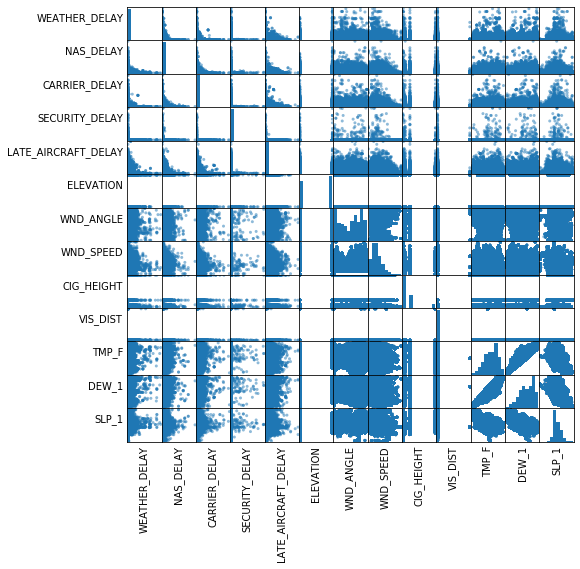

In [78]:
from pandas.plotting import scatter_matrix

def check_correlation():
  # outcome variable
  LABEL = "DEP_DEL15"

  df = airlines_weather
  df = df.na.drop()

  features = df.columns
  features.remove(LABEL)

  numeric_data = df.select(features).toPandas()
  axs = scatter_matrix(numeric_data, figsize=(8, 8));
  n = len(numeric_data.columns)
  for i in range(n):
      v = axs[i, 0]
      v.yaxis.label.set_rotation(0)
      v.yaxis.label.set_ha('right')
      v.set_yticks(())
      h = axs[n-1, i]
      h.xaxis.label.set_rotation(90)
      h.set_xticks(())
      
#check_correlation()

In [79]:
# Making a sample set of the full joined dataset do the Correlation Matrix 
airlines_weather_all_sample_df = airlines_weather_all_sample.sample(False, 0.001, 42)
print(weather_sample.count())
airlines_weather_all_sample_pd = airlines_weather_all_sample_df.toPandas()

# Get the related features
FIELDS = airlines_weather_all_sample_df.columns

# plot heatmap for correlations matrix 
corr = airlines_weather_all_sample_pd[FIELDS[:]].corr()
fig, ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
plt.title("Correlations between the selected features.")
display(plt.show())

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-1133838164076571> in <module> 
 1 # Making a sample set of the full joined dataset do the Correlation Matrix 
 ----> 2 airlines_weather_all_sample_df = airlines_weather_all_sample . sample ( False , 0.001 , 42 ) 
 3 print ( weather_sample . count ( ) ) 
 4 airlines_weather_all_sample_pd = airlines_weather_all_sample_df . toPandas ( ) 
 5 

 NameError : name 'airlines_weather_all_sample' is not defined

### Baseline Model

##### split feature and label 

[most code is from here](https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa)

##### Instructions from BTS.gov

[How many flights were really delayed by weather?](https://www.bts.gov/topics/airlines-and-airports/understanding-reporting-causes-flight-delays-and-cancellations)
- A true picture of total weather-related delays requires several steps. 
- First, the extreme weather delays must be combined with the NAS weather category. 
- Second, a calculation must be made to determine the weather-related delays included in the "late-arriving aircraft" category. Airlines do not report the causes of the late-arriving aircraft but an allocation can be made using the proportion of weather related-delays and total flights in the other categories. 
- Adding the weather-related delays to the extreme weather and NAS weather categories would result in weather's share of all flight delays.

Use `DEP_DEL15` as our target variable, and using the following as input variables.

In [81]:
# ['DEP_DEL15', 'WEATHER_DELAY', 'NAS_DELAY', 'CARRIER_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'DEP_TIME', 'FL_DATE', 'DEP_HOUR', 'AIRPORT_ORG', 'ORIGIN_LAT', 'ORIGIN_LON', 'ORG_WS_ID', 'AIRPORT_DEST', 'DEST_LAT', 'DEST_LON', 'DEST_WS_ID', 'ORG_WS_ID_2', 'ORG_ELEVATION', 'ORG_WND_ANGLE', 'ORG_WND_SPEED', 'ORG_CIG_HEIGHT', 'ORG_VIS_DIST', 'ORG_TMP_F', 'ORG_DEW_1', 'ORG_SLP_1', 'ORG_LATITUDE', 'ORG_LONGITUDE', 'ORG_DATE', 'ORG_DATE_PART', 'ORG_HOUR_PART', 'DEST_WS_ID_2', 'DEST_ELEVATION', 'DEST_WND_ANGLE', 'DEST_WND_SPEED', 'DEST_CIG_HEIGHT', 'DEST_VIS_DIST', 'DEST_TMP_F', 'DEST_DEW_1', 'DEST_SLP_1', 'DEST_LATITUDE', 'DEST_LONGITUDE', 'DEST_DATE', 'DEST_DATE_PART', 'DEST_HOUR_PART']

#variables_tokeep = ['DEP_DEL15', 'WEATHER_DELAY', 'NAS_DELAY', 'CARRIER_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'ELEVATION', 'WND_ANGLE', 'WND_SPEED', 'CIG_HEIGHT', 'VIS_DIST', 'TMP_F', 'DEW_1', 'SLP_1']
#variables_tokeep = ['DEP_DEL15', 'CARRIER_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'ELEVATION', 'WND_ANGLE', 'WND_SPEED', 'CIG_HEIGHT', 'VIS_DIST', 'TMP_F', 'DEW_1', 'SLP_1']

#without delay
#variables_tokeep = ['DEP_DEL15', 'ELEVATION', 'WND_ANGLE', 'WND_SPEED', 'CIG_HEIGHT', 'VIS_DIST', 'TMP_F', 'DEW_1', 'SLP_1']

#variables_tokeep = ['DEP_DEL15', 'ORG_ELEVATION', 'ORG_WND_ANGLE', 'ORG_WND_SPEED', 'ORG_CIG_HEIGHT', 'ORG_VIS_DIST', 'ORG_TMP_F', 'ORG_DEW_1', 'ORG_SLP_1', 'DEST_ELEVATION', 'DEST_WND_ANGLE', 'DEST_WND_SPEED', 'DEST_CIG_HEIGHT', 'DEST_VIS_DIST', 'DEST_TMP_F', 'DEST_DEW_1', 'DEST_SLP_1']

def filter_features(airline_weather):
    variables_tokeep = ['DEP_DEL15', 'ORG_WND_ANGLE', 'ORG_WND_SPEED', 'ORG_CIG_HEIGHT', 'ORG_VIS_DIST', 'ORG_TMP_F', 'DEST_WND_ANGLE', 'DEST_WND_SPEED', 'DEST_CIG_HEIGHT', 'DEST_VIS_DIST', 'DEST_TMP_F']
    
    return airline_weather.select(variables_tokeep)

#airlines_weather_all_sample 726465
#airlines_weather_all_test 16530825
#airlines_weather_all_train 53118180
airlines_weather_sample = filter_features(airlines_weather_all_sample)
airlines_weather_test = filter_features(airlines_weather_all_test)
airlines_weather_train = filter_features(airlines_weather_all_train)

USE_SAMPLE_ONLY = False

# outcome variable
LABEL = "DEP_DEL15"
  
def label_dataset(airlines_weather):
    

    df = airlines_weather
    df = df.na.drop()

    features = df.columns
    features.remove(LABEL)

    # Set up a ML pipeline
    stages = []

    assembler = VectorAssembler(inputCols=features, outputCol="features")
    stages += [assembler]

    pipeline = Pipeline(stages = stages)
    pipelineModel = pipeline.fit(df)
    df = pipelineModel.transform(df)

    selectedCols = [LABEL, 'features'] + features
    df = df.select(selectedCols)
    return df 

#if using sample set
train, test = None, None
if USE_SAMPLE_ONLY:
    df = label_dataset(airlines_weather_sample)
    train, test = df.randomSplit([0.8, 0.2], seed = 42)
else:
  train = label_dataset(airlines_weather_train)
  test = label_dataset(airlines_weather_test)


#### Logistic Regression

In [83]:

#TODO separate training and evaluation 
def run_LR(label, train, test):
  lr = LogisticRegression(featuresCol = 'features', labelCol = label, maxIter=10)
  lrModel = lr.fit(train)

  trainingSummary = lrModel.summary
  roc = trainingSummary.roc.toPandas()

  #evaluation
  predictions = lrModel.transform(test)
  evaluator = BinaryClassificationEvaluator().setLabelCol(label)
  print('Test Area Under ROC', evaluator.evaluate(predictions))
  
run_LR(LABEL, train, test)

/databricks/spark/python/pyspark/sql/context.py:119: DeprecationWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
 DeprecationWarning)
Test Area Under ROC 0.9012463557578926

#### Decision Tree Classifer

In [85]:
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = LABEL, maxDepth = 6)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
#predictions.select(LABEL, 'rawPrediction', 'prediction', 'probability').show(10)

evaluator = BinaryClassificationEvaluator().setLabelCol(LABEL)
print('Test Area Under ROC', evaluator.evaluate(predictions))
#print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-3272733155786663> in <module> 
 1 from pyspark . ml . classification import DecisionTreeClassifier
 ----> 2 dt = DecisionTreeClassifier ( featuresCol = 'features' , labelCol = LABEL , maxDepth = 6 ) 
 3 dtModel = dt . fit ( train ) 
 4 predictions = dtModel . transform ( test ) 
 5 #predictions.select(LABEL, 'rawPrediction', 'prediction', 'probability').show(10) 

 NameError : name 'LABEL' is not defined

#### Random Forest Classifier

In [87]:

def run_RF(label, train, test):
    rf = RandomForestClassifier(featuresCol = 'features', labelCol = label)
    rfModel = rf.fit(train)
    predictions = rfModel.transform(test)

    evaluator = BinaryClassificationEvaluator().setLabelCol(label)
    print('Test Area Under ROC', evaluator.evaluate(predictions))
    
run_RF(LABEL, train, test)

Test Area Under ROC 0.9101122474551796

#### Gradient-Boosted Tree Classifier

In [89]:

def run_GBT(label, train, test):
    gbt = GBTClassifier(maxIter=10, featuresCol = 'features', labelCol = label)
    gbtModel = gbt.fit(train)
    predictions = gbtModel.transform(test)

    evaluator = BinaryClassificationEvaluator().setLabelCol(label)
    print('Test Area Under ROC', evaluator.evaluate(predictions))
    
run_GBT(LABEL, train, test)  

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-3272733155787310> in <module> 
 1 from pyspark . ml . classification import GBTClassifier
 ----> 2 gbt = GBTClassifier ( maxIter = 10 , featuresCol = 'features' , labelCol = LABEL ) 
 3 gbtModel = gbt . fit ( train ) 
 4 predictions = gbtModel . transform ( test ) 
 5 

 NameError : name 'LABEL' is not defined